In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

pd.set_option('display.max_columns', 500)  # Sütun sayısı sınırı yok
pd.set_option('display.expand_frame_repr', False)  # DataFrame'i satırlara bölmeden göster
pd.set_option('display.width', 10000)  # Genişlik arttır (gerekirse 2000 yap)
# 10 basamak göster PEPE için
pd.set_option("display.float_format", lambda x: f"{x:.10f}")


# Relative Strength Index (RSI)

In [ ]:
def calculate_rsi(price_data, window=14, price_col='close'):
    """
    Correct RSI calculation.
    """
    delta = price_data[price_col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


# Categorical RSI  

In [ ]:
def categorize_rsi(rsi_series):
    """
    Categorize RSI values into bins:
    0-30, 30-50, 50-70, 70-100

    Args:
        rsi_series (pd.Series): RSI values

    Returns:
        pd.Series: Categorical RSI bins
    """
    bins = [0, 30, 50, 70, 100]
    labels = ['oversold', 'below_avg', 'above_avg', 'overbought']
    return pd.cut(rsi_series, bins=bins, labels=labels, include_lowest=True)


# Average True Range (ATR)

In [ ]:
def calculate_atr(price_data, window=14):
    """
    Calculate ATR (Average True Range) using Wilder's RMA.

    Args:
        price_data (pd.DataFrame): DataFrame containing columns 'high', 'low', 'close'
        window (int): Lookback period (default: 14)

    Returns:
        pd.Series: ATR values
    """
    high = price_data['high']
    low = price_data['low']
    close = price_data['close']

    # Calculate True Range (TR)
    previous_close = close.shift(1)
    tr1 = high - low
    tr2 = abs(high - previous_close)
    tr3 = abs(low - previous_close)
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR = RMA of True Range
    atr = true_range.ewm(alpha=1/window, adjust=False).mean()

    return atr

# Bollinger Bands

In [ ]:
def calculate_bollinger_bands(price_data, window=20, std_multiplier=2, price_col='close'):
    """
    Calculate Bollinger Bands.

    Args:
        price_data (pd.DataFrame): DataFrame containing OHLC prices
        window (int): Lookback period for SMA (default: 20)
        std_multiplier (float): Standard deviation multiplier (default: 2)
        price_col (str): Column name for price (default: 'close')

    Returns:
        pd.DataFrame: DataFrame with 'bb_middle', 'bb_upper', 'bb_lower' columns
    """
    price = price_data[price_col]

    # Middle Band: SMA
    sma = price.rolling(window=window).mean()

    # Standard Deviation
    std = price.rolling(window=window).std()

    # Upper and Lower Bands
    upper_band = sma + std_multiplier * std
    lower_band = sma - std_multiplier * std

    # Return as DataFrame
    bb = pd.DataFrame({
        'bb_middle': sma,
        'bb_upper': upper_band,
        'bb_lower': lower_band
    })

    return bb


# Donchain Channels

In [ ]:
#USE 20, 50 OR 55

def calculate_donchian_channel(price_data, window=20):
    """
    Calculate Donchian Channel.

    Args:
        price_data (pd.DataFrame): DataFrame with 'high' and 'low' columns
        window (int): Lookback period (default: 20)

    Returns:
        pd.DataFrame: DataFrame with 'dc_upper', 'dc_lower', 'dc_middle'
    """
    upper_band = price_data['high'].rolling(window=window).max()
    lower_band = price_data['low'].rolling(window=window).min()
    middle_band = (upper_band + lower_band) / 2

    dc = pd.DataFrame({
        'dc_upper': upper_band,
        'dc_lower': lower_band,
        'dc_middle': middle_band
    })

    return dc


# Simple Moving Average - SMA

In [ ]:
# USE 13, 50, 100 OR 200

def calculate_sma(price_data, window=50, price_col='close'):
    """
    Calculate Simple Moving Average (SMA).

    Args:
        price_data (pd.DataFrame): DataFrame containing price data
        window (int): Lookback period for SMA (default: 50)
        price_col (str): Column name for price (default: 'close')

    Returns:
        pd.Series: SMA values
    """
    sma = price_data[price_col].rolling(window=window).mean()
    return sma


# Trend

In [ ]:
def determine_sma_trend(price_data, short_window=50, long_window=200, price_col='close'):
    """
    Determine trend based on SMA crossover.

    Args:
        price_data (pd.DataFrame): DataFrame containing price data
        short_window (int): Short SMA period (default: 13)
        long_window (int): Long SMA period (default: 50)
        price_col (str): Column name for price (default: 'close')

    Returns:
        pd.Series: Trend labels ('uptrend' or 'downtrend')
    """
    short_sma = price_data[price_col].rolling(window=short_window).mean()
    long_sma = price_data[price_col].rolling(window=long_window).mean()

    trend = np.where(short_sma > long_sma, 'uptrend', 'downtrend')

    return pd.Series(trend, index=price_data.index)


# EMA

In [ ]:
def calculate_ema(df, window=50, column='close'):
    """
    DataFrame için EMA (Exponential Moving Average) hesaplar

    Parameters:
    df (pd.DataFrame): Fiyat verilerini içeren DataFrame
    window (int): EMA periyodu (varsayılan: 50)
    column (str): Kullanılacak sütun adı (varsayılan: 'close')

    Returns:
    pd.Series: Hesaplanan EMA değerleri
    """

    # Düzgünleştirme faktörü (alpha)
    alpha = 2 / (window + 1)

    # EMA hesaplama - pandas ewm fonksiyonu kullanarak
    ema = df[column].ewm(alpha=alpha, adjust=False).mean()

    return ema

# Nadaraya Watson Envelope

In [ ]:
def calculate_nadaraya_watson_envelope_optimized(df, bandwidth=8.0, multiplier=3.0, source_col='close', window_size=50):# window_size=500 kullanımı da var.
    """
    Nadaraya-Watson Envelope'un repaint olmayan modunu hesaplar.
    Sadece hesaplanan 'nw_lower', 'nw', 'nw_upper' sütunlarını içeren bir DataFrame döndürür.

    Parametreler:
    df (pd.DataFrame): 'close', 'open', 'high', 'low', 'time' sütunlarına sahip DataFrame.
    bandwidth (float): Nadaraya-Watson için bant genişliği (h).
    multiplier (float): Zarfların genişliğini ayarlamak için çarpan.
    source_col (str): Hesaplama için kullanılacak kaynak sütun adı (örn: 'close').
    window_size (int): Nadaraya-Watson ve MAE hesaplamalarında kullanılacak maksimum geçmiş bar sayısı.

    Döndürür:
    pd.DataFrame: 'nw_lower', 'nw', 'nw_upper' sütunlarını içeren yeni bir DataFrame.
                  Bu DataFrame'in indeksleri orijinal df ile aynı olacaktır.
    """

    n_bars = len(df)
    source_data = df[source_col].values # NumPy array'ine dönüştürerek erişimi hızlandır

    # Gaussian kernel fonksiyonu
    def gauss(x, h):
        return np.exp(-(x**2) / (h * h * 2))

    # Ağırlıkları bir kere hesapla
    weights = np.array([gauss(i, bandwidth) for i in range(window_size)])
    weights_sum = np.sum(weights)

    # Sonuçları saklamak için NumPy array'leri oluştur (önceden bellek tahsisi)
    nw_out_arr = np.full(n_bars, np.nan)
    nw_lower_arr = np.full(n_bars, np.nan)
    nw_upper_arr = np.full(n_bars, np.nan)

    # Her bar için hesaplama yap
    for i in range(n_bars):
        if i < window_size - 1:
            continue

        # Nadaraya-Watson çizgisi (nw_out) hesaplaması
        # NumPy dilimleme ve dot product kullanarak hızlandırılmış hesaplama
        # source_data[i - window_size + 1 : i + 1] son 'window_size' kadar veriyi alır
        # weights[::-1] ağırlıkları ters çevirir çünkü en yakın veriye en yüksek ağırlık gelir
        weighted_sum = np.dot(source_data[i - window_size + 1 : i + 1], weights[::-1])

        current_nw_out = weighted_sum / weights_sum
        nw_out_arr[i] = current_nw_out

        # MAE hesaplaması (Artık 'nw_out_arr' değerlerini kullanarak daha doğru bir MAE)
        # Sadece yeterli geçmiş veri olduğunda hesapla
        if i >= window_size -1:
            # Geçmiş src ve nw_out farklarını al
            abs_diffs = np.abs(source_data[i - window_size + 1 : i + 1] - nw_out_arr[i - window_size + 1 : i + 1])
            current_mae = np.mean(abs_diffs) * multiplier # ta.sma'ya benzer

            nw_lower_arr[i] = current_nw_out - current_mae
            nw_upper_arr[i] = current_nw_out + current_mae

    # Sonuçları yeni bir DataFrame olarak döndür
    results_df = pd.DataFrame({
        'nw': nw_out_arr,
        'nw_upper': nw_upper_arr,
        'nw_lower': nw_lower_arr
    }, index=df.index) # Orijinal DataFrame'in indeksini koru

    return results_df

# Supertrend

In [ ]:
def calculate_supertrend(price_data, atr_period=10, multiplier=3):
    """
    Calculate SuperTrend indicator.

    Args:
        price_data (pd.DataFrame): DataFrame containing 'high', 'low', 'close'
        atr_period (int): ATR lookback period (default: 10)
        multiplier (float): ATR multiplier (default: 3)

    Returns:
        pd.DataFrame: DataFrame with 'supertrend', 'supertrend_direction', 'supertrend_signal'
    """
    high = price_data['high']
    low = price_data['low']
    close = price_data['close']

    # ATR
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(atr_period).mean()

    # Basic Bands
    hl2 = (high + low) / 2
    upper_band = hl2 + multiplier * atr
    lower_band = hl2 - multiplier * atr

    # Final Bands & Trend
    supertrend = np.full(len(close), np.nan)
    direction = np.full(len(close), True)  # True: uptrend, False: downtrend

    for i in range(atr_period, len(close)):
        if close[i] > upper_band[i-1]:
            direction[i] = True
        elif close[i] < lower_band[i-1]:
            direction[i] = False
        else:
            direction[i] = direction[i-1]

            if direction[i] and lower_band[i] < lower_band[i-1]:
                lower_band[i] = lower_band[i-1]
            if not direction[i] and upper_band[i] > upper_band[i-1]:
                upper_band[i] = upper_band[i-1]

        supertrend[i] = lower_band[i] if direction[i] else upper_band[i]

    trend_label = np.where(direction, 'uptrend', 'downtrend')

    # Signal: True if trend changes this bar
    signal = np.full(len(close), np.nan)
    signal[atr_period:] = direction[atr_period:] != direction[atr_period-1:-1]

    result = pd.DataFrame({
        'supertrend': supertrend,
        'supertrend_direction': trend_label,
        'supertrend_signal': signal
    }, index=price_data.index)

    return result


# Stochastic

In [ ]:
def calculate_stochastic(price_data, k_length=50, k_smoothing=21, d_smoothing=8):
    """
    TradingView style Stochastic Oscillator.

    Args:
        price_data (pd.DataFrame): must have 'High', 'Low', 'Close'
        k_length (int): %K Length (lookback)
        k_smoothing (int): %K Smoothing
        d_smoothing (int): %D Smoothing

    Returns:
        pd.DataFrame: 'stoch_k', 'stoch_d'
    """
    low_min = price_data['low'].rolling(window=k_length).min()
    high_max = price_data['high'].rolling(window=k_length).max()

    raw_k = 100 * (price_data['close'] - low_min) / (high_max - low_min)
    stoch_k = raw_k.rolling(window=k_smoothing).mean()
    stoch_d = stoch_k.rolling(window=d_smoothing).mean()

    return pd.DataFrame({
        'stoch_k': stoch_k,
        'stoch_d': stoch_d
    })


# Stochastic RSI

In [ ]:
def rma(series, length):
    """Wilder's RMA: TradingView'deki ta.rma ile birebir."""
    alpha = 1 / length
    rma = series.ewm(alpha=alpha, adjust=False).mean()
    return rma

def calculate_stoch_rsi(
    price_data,
    rsi_length=14,
    stoch_length=14,
    k_smoothing=21,
    d_smoothing=8,
    price_col='close'
):
    """
    TradingView birebir Stoch RSI — RMA tabanlı

    Returns:
        'stoch_rsi_k', 'stoch_rsi_d' (0-100)
    """
    # 1) RSI (RMA tabanlı)
    delta = price_data[price_col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = rma(gain, rsi_length)
    avg_loss = rma(loss, rsi_length)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # 2) Stoch RSI
    rsi_min = rsi.rolling(window=stoch_length).min()
    rsi_max = rsi.rolling(window=stoch_length).max()

    stoch_rsi = 100 * (rsi - rsi_min) / (rsi_max - rsi_min)
    stoch_rsi = stoch_rsi.clip(0, 100)

    # 3) %K ve %D smoothing — RMA tabanlı
    stoch_rsi_k = rma(stoch_rsi, k_smoothing)
    stoch_rsi_d = rma(stoch_rsi_k, d_smoothing)

    return pd.DataFrame({
        'stoch_rsi_k': stoch_rsi_k,
        'stoch_rsi_d': stoch_rsi_d
    })


# MACD

In [ ]:
def calculate_macd(price_data, fast=21, slow=50, signal=9, price_col='close'):
    """
    Calculate MACD and Signal Line.

    Args:
        price_data (pd.DataFrame): must have price_col
        fast (int): Fast EMA period
        slow (int): Slow EMA period
        signal (int): Signal line EMA period

    Returns:
        pd.DataFrame: 'macd_line', 'macd_signal', 'macd_hist'
    """
    ema_fast = price_data[price_col].ewm(span=fast, adjust=False).mean()
    ema_slow = price_data[price_col].ewm(span=slow, adjust=False).mean()

    macd_line = ema_fast - ema_slow
    macd_signal = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - macd_signal

    return pd.DataFrame({
        'macd_line': macd_line,
        'macd_signal': macd_signal,
        'macd_hist': macd_hist
    })


# ADX

In [ ]:
def add_adx(df, period=14):
    """
    DataFrame'e ADX (Average Directional Index) göstergesini ekler.

    Parametreler:
    df (pd.DataFrame): 'high', 'low' ve 'close' sütunlarını içeren DataFrame.
                       Sütun isimlerinin küçük harf olduğundan emin olun.
    period (int): ADX hesaplaması için kullanılacak periyot (varsayılan 14).

    Döndürür:
    pd.DataFrame: ADX, +DI, -DI ve DX sütunları eklenmiş DataFrame.
    """

    # Gerekli sütunların küçük harf kontrolü ve hata yönetimi
    required_cols = ['high', 'low', 'close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame'de '{', '.join(required_cols)}' sütunları bulunmalıdır ve küçük harf olmalıdır.")

    # Geçici çalışma DataFrame'i oluştur (orijinal df'i değiştirmemek için kopyala)
    df_adx = df.copy()

    # --- Yardımcı EMA Hesaplama Fonksiyonu ---
    def _calculate_ema(series, p):
        ema_values = [np.nan] * len(series)
        if len(series) < p:
            return pd.Series(ema_values, index=series.index)

        # İlk EMA değeri için SMA kullanılır
        ema_values[p - 1] = series.iloc[:p].mean()

        alpha = 2 / (p + 1)
        for i in range(p, len(series)):
            ema_values[i] = (series.iloc[i] * alpha) + (ema_values[i-1] * (1 - alpha))

        return pd.Series(ema_values, index=series.index)

    # --- 1. Adım: True Range (TR) Hesapla ---
    # TR = Max[(high - low), abs(high - prev_close), abs(low - prev_close)]
    df_adx['prev_close'] = df_adx['close'].shift(1)
    df_adx['high_low'] = df_adx['high'] - df_adx['low']
    df_adx['high_prev_close'] = abs(df_adx['high'] - df_adx['prev_close'])
    df_adx['low_prev_close'] = abs(df_adx['low'] - df_adx['prev_close'])
    df_adx['tr'] = df_adx[['high_low', 'high_prev_close', 'low_prev_close']].max(axis=1)

    # --- 2. Adım: Directional Movement (+DM ve -DM) Hesapla ---
    df_adx['prev_high'] = df_adx['high'].shift(1)
    df_adx['prev_low'] = df_adx['low'].shift(1)
    df_adx['up_move'] = df_adx['high'] - df_adx['prev_high']
    df_adx['down_move'] = df_adx['prev_low'] - df_adx['low']

    df_adx['+dm'] = np.where(
        (df_adx['up_move'] > df_adx['down_move']) & (df_adx['up_move'] > 0),
        df_adx['up_move'],
        0
    )
    df_adx['-dm'] = np.where(
        (df_adx['down_move'] > df_adx['up_move']) & (df_adx['down_move'] > 0),
        df_adx['down_move'],
        0
    )

    # --- 3. Adım: ATR, +DM ve -DM'nin Üssel Hareketli Ortalamalarını (EMA) Hesapla ---
    df_adx['tr_ema'] = _calculate_ema(df_adx['tr'], period)
    df_adx['+dm_ema'] = _calculate_ema(df_adx['+dm'], period)
    df_adx['-dm_ema'] = _calculate_ema(df_adx['-dm'], period)

    # --- 4. Adım: Yönsel İndeksler (DI) Hesapla ---
    df_adx['+di'] = (df_adx['+dm_ema'] / df_adx['tr_ema']) * 100
    df_adx['-di'] = (df_adx['-dm_ema'] / df_adx['tr_ema']) * 100

    # Sonsuzlukları ve sıfıra bölme hatalarını yönet
    df_adx['+di'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_adx['-di'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_adx.loc[df_adx['tr_ema'] == 0, ['+di', '-di']] = np.nan

    # --- 5. Adım: Yönsel Hareket İndeksi (DX) Hesapla ---
    df_adx['dx'] = (abs(df_adx['+di'] - df_adx['-di']) / (df_adx['+di'] + df_adx['-di'])) * 100
    df_adx['dx'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_adx.loc[(df_adx['+di'] + df_adx['-di']) == 0, 'dx'] = np.nan

    # --- 6. Adım: ADX Hesapla (DX'in EMA'sı) ---
    df_adx['adx'] = _calculate_ema(df_adx['dx'], period)

    # İstenirse ara hesaplama sütunlarını temizle
    # df_adx.drop(columns=['prev_close', 'high_low', 'high_prev_close', 'low_prev_close',
    #                      'prev_high', 'prev_low', 'up_move', 'down_move',
    #                      'tr', '+dm', '-dm', 'tr_ema', '+dm_ema', '-dm_ema', 'dx'],
    #                     errors='ignore', inplace=True)

    return df_adx

# OBV

In [ ]:
def add_obv(df):
    """
    DataFrame'e OBV (On-Balance Volume) göstergesini ekler.

    Parametreler:
    df (pd.DataFrame): 'close' ve 'volume' sütunlarını içeren DataFrame.
                       Sütun isimlerinin küçük harf olduğundan emin olun.

    Döndürür:
    pd.DataFrame: 'obv' sütunu eklenmiş DataFrame.
    """

    # Gerekli sütunların küçük harf kontrolü ve hata yönetimi
    required_cols = ['close', 'volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame'de '{', '.join(required_cols)}' sütunları bulunmalıdır ve küçük harf olmalıdır.")

    # Geçici çalışma DataFrame'i oluştur (orijinal df'i değiştirmemek için kopyala)
    df_obv = df.copy()

    # OBV sütununu başlat, ilk değeri 0 veya ilk barın hacmi olabilir.
    # Genellikle ilk barın hacmi alınır.
    df_obv['obv'] = 0.0 # float olarak başlat

    # İlk OBV değeri: İlk kapanış ve hacim verisi kullanılarak belirlenir
    # df_obv['obv'].iloc[0] = df_obv['volume'].iloc[0] # Bu da bir yaklaşım
    # Ancak sıfırdan başlamak da yaygındır ve sonraki hesaplamayı etkilemez

    # Döngü ile OBV'yi hesapla
    for i in range(1, len(df_obv)):
        # Kapanış fiyatlarının önceki kapanışa göre karşılaştırılması
        if df_obv['close'].iloc[i] > df_obv['close'].iloc[i-1]:
            # Fiyat yükseldi, hacmi ekle
            df_obv['obv'].iloc[i] = df_obv['obv'].iloc[i-1] + df_obv['volume'].iloc[i]
        elif df_obv['close'].iloc[i] < df_obv['close'].iloc[i-1]:
            # Fiyat düştü, hacmi çıkar
            df_obv['obv'].iloc[i] = df_obv['obv'].iloc[i-1] - df_obv['volume'].iloc[i]
        else:
            # Fiyat değişmedi, OBV aynı kalır
            df_obv['obv'].iloc[i] = df_obv['obv'].iloc[i-1]

    return df_obv

# Candle

In [ ]:
def candle(df):
    if df['close'] > df['open']:
        return'green'
    else:
        return 'red'

def classify_strength(row):
    if row['close'] > row['open']:
        if row['candle_strength'] > 1.1:
            return 'strong_bullish'
        elif row['candle_strength'] > 0.7:
            return 'medium_bullish'
        else:
            return 'weak_bullish'
    else:
        if row['candle_strength'] > 1.1:
            return 'strong_bearish'
        elif row['candle_strength'] > 0.7:
            return 'medium_bearish'
        else:
            return 'weak_bearish'

# DATAFRAME

In [ ]:
#df = pd.read_csv('/content/TRX_USD_1h_2y.csv',header=0, skiprows=[1,2])
#df = df.rename(columns={'Price': 'datetime',})
#df.columns = df.columns.str.lower()
#df['datetime'] = pd.to_datetime(df['datetime'])

df = pd.read_csv('/content/BINANCE_ETHUSDT, 60.csv')
df.columns = df.columns.str.lower()
df['time'] = pd.to_datetime(df['time'])

df.tail()

,time,open,high,low,close,volume,histogram,macd,signal,atr
22573,2025-07-29 18:00:00+03:00,3782.2500000000,3783.5000000000,3747.0000000000,3761.5700000000,42823.3068000000,-2.9193689754,3.5171521088,6.4365210842,38.8082878696
22574,2025-07-29 19:00:00+03:00,3761.5600000000,3769.1600000000,3716.0400000000,3751.4500000000,53294.9354000000,-5.1832405549,-0.0425296095,5.1407109454,39.8305530218
22575,2025-07-29 20:00:00+03:00,3751.4500000000,3793.5900000000,3744.5200000000,3769.7400000000,29867.9217000000,-5.8774287829,-2.2060750332,3.6713537497,40.4905135202
22576,2025-07-29 21:00:00+03:00,3769.7300000000,3776.5700000000,3752.4800000000,3770.9900000000,10975.6851000000,-6.1557399712,-4.0233212143,2.1324187569,39.3190482688
22577,2025-07-29 22:00:00+03:00,3771.0000000000,3773.1700000000,3768.5300000000,3771.6100000000,662.5571000000,-6.1572821535,-5.5641839349,0.5930982185,36.8419733924


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22578 entries, 0 to 22577
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype                    
---  ------     --------------  -----                    
 0   time       22578 non-null  datetime64[ns, UTC+03:00]
 1   open       22578 non-null  float64                  
 2   high       22578 non-null  float64                  
 3   low        22578 non-null  float64                  
 4   close      22578 non-null  float64                  
 5   volume     22578 non-null  float64                  
 6   histogram  22521 non-null  float64                  
 7   macd       22529 non-null  float64                  
 8   signal     22521 non-null  float64                  
 9   atr        22565 non-null  float64                  
dtypes: datetime64[ns, UTC+03:00](1), float64(9)
memory usage: 1.7 MB


In [ ]:
df['volume'].describe()

,volume
count,22578.0000000000
mean,18315.0960106210
std,20447.5822954093
min,662.5571000000
25%,7417.5499000000
50%,12334.3337000000
75%,21501.6077500000
max,508838.4049000000


## Creating Main Columns

In [ ]:
df['rsi'] = calculate_rsi(df)
df['cat_rsi'] = categorize_rsi(df['rsi'])
df['rsi_40'] = calculate_rsi(df, window=40)
df['atr'] = calculate_atr(df)

bb = calculate_bollinger_bands(df)
df['bb_middle'] = bb['bb_middle']
df['bb_upper'] = bb['bb_upper']
df['bb_lower'] = bb['bb_lower']

dc = calculate_donchian_channel(df, window=20)
df['dc_upper_20'] = dc['dc_upper']
df['dc_lower_20'] = dc['dc_lower']
df['dc_middle_20'] = dc['dc_middle']

dc = calculate_donchian_channel(df, window=50)
df['dc_upper_50'] = dc['dc_upper']
df['dc_lower_50'] = dc['dc_lower']
df['dc_middle_50'] = dc['dc_middle']

df['sma_50'] = calculate_sma(df,window=50)
df['sma_200'] = calculate_sma(df,window=200)
df['sma_200_4h'] = calculate_sma(df,window=800)
df['sma_50_rate'] = df['close'] / df['sma_50']


df['trend_13_50']=determine_sma_trend(df, short_window=13, long_window=50)
df['trend_50_200']=determine_sma_trend(df, short_window=50, long_window=200)
df['trend_4h_50_200']=determine_sma_trend(df, short_window=200, long_window=800)

df['ema'] = calculate_ema(df, window=50)
df['ema_20'] = calculate_ema(df, window=20)
df['ema_50_rate'] = df['close'] / df['ema']
df['ema_20_rate'] = df['close'] / df['ema_20']

nw_bands = calculate_nadaraya_watson_envelope_optimized(df, bandwidth=8.0, multiplier=3.0, source_col='close', window_size=50)
df['nw'] = nw_bands['nw']
df['nw_upper'] = nw_bands['nw_upper']
df['nw_lower'] = nw_bands['nw_lower']


st = calculate_supertrend(df, atr_period=10, multiplier=3)
df['supertrend'] = st['supertrend']
df['supertrend_direction'] = st['supertrend_direction']
df['supertrend_signal'] = st['supertrend_signal']

stoch = calculate_stochastic(df)
df['stoch_k'] = stoch['stoch_k']
df['stoch_d'] = stoch['stoch_d']

stoch_rsi = calculate_stoch_rsi(df)
df['stoch_rsi_k'] = stoch_rsi['stoch_rsi_k']
df['stoch_rsi_d'] = stoch_rsi['stoch_rsi_d']

macd = calculate_macd(df)
df['macd_line'] = macd['macd_line'] # blue line
df['macd_signal'] = macd['macd_signal'] # orange line
df['macd_hist'] = macd['macd_hist']


df['candle'] = df.apply(candle, axis=1)
df['candle_body'] = abs(df['close'] - df['open'])
df['candle_strength'] = df['candle_body'] / df['atr']
df['candle_class'] = df.apply(classify_strength, axis=1)

df['volume_price'] = df['volume'] / df['close']
df['volume_candle'] = df['volume'] * abs(df['close'] - df['open']) / df['close']

df = add_adx(df, period=14)

df = add_obv(df)




/tmp/ipython-input-3933902896.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_adx['+di'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-3933902896.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [ ]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'histogram', 'macd', 'signal', 'atr', 'rsi', 'cat_rsi', 'rsi_40', 'bb_middle', 'bb_upper', 'bb_lower', 'dc_upper_20', 'dc_lower_20', 'dc_middle_20', 'dc_upper_50', 'dc_lower_50', 'dc_middle_50', 'sma_50', 'sma_200', 'sma_200_4h', 'sma_50_rate', 'trend_13_50', 'trend_50_200', 'trend_4h_50_200', 'ema', 'ema_20', 'ema_50_rate', 'ema_20_rate', 'nw', 'nw_upper', 'nw_lower', 'supertrend', 'supertrend_direction', 'supertrend_signal', 'stoch_k', 'stoch_d', 'stoch_rsi_k', 'stoch_rsi_d', 'macd_line', 'macd_signal', 'macd_hist', 'candle', 'candle_body', 'candle_strength', 'candle_class', 'volume_price', 'volume_candle', 'prev_close', 'high_low', 'high_prev_close', 'low_prev_close', 'tr', 'prev_high', 'prev_low', 'up_move', 'down_move', '+dm', '-dm', 'tr_ema', '+dm_ema', '-dm_ema', '+di', '-di', 'dx', 'adx', 'obv'], dtype='object')

In [ ]:
df.tail(5)

,time,open,high,low,close,volume,histogram,macd,signal,atr,rsi,cat_rsi,rsi_40,bb_middle,bb_upper,bb_lower,dc_upper_20,dc_lower_20,dc_middle_20,dc_upper_50,dc_lower_50,dc_middle_50,sma_50,sma_200,sma_200_4h,sma_50_rate,trend_13_50,trend_50_200,trend_4h_50_200,ema,ema_20,ema_50_rate,ema_20_rate,nw,nw_upper,nw_lower,supertrend,supertrend_direction,supertrend_signal,stoch_k,stoch_d,stoch_rsi_k,stoch_rsi_d,macd_line,macd_signal,macd_hist,candle,candle_body,candle_strength,candle_class,volume_price,volume_candle,prev_close,high_low,high_prev_close,low_prev_close,tr,prev_high,prev_low,up_move,down_move,+dm,-dm,tr_ema,+dm_ema,-dm_ema,+di,-di,dx,adx,obv
22573,2025-07-29 18:00:00+03:00,3782.2500000000,3783.5000000000,3747.0000000000,3761.5700000000,42823.3068000000,-2.9193689754,3.5171521088,6.4365210842,38.8082878696,50.4268079840,above_avg,42.1834999929,3809.0810000000,3885.9936796471,3732.1683203529,3886.4400000000,3731.2100000000,3808.8250000000,3941.0000000000,3731.2100000000,3836.1050000000,3833.6370000000,3737.5102000000,3058.7481000000,0.9812014022,downtrend,uptrend,uptrend,3814.1260926340,3817.4392961230,0.9862206725,0.9853647192,3820.0183898629,3917.7887502748,3722.2480294510,3758.2240000000,uptrend,0.0000000000,37.1810780845,37.4628416653,49.5844940093,47.3323971860,3.5171521088,6.4365210841,-2.9193689754,red,20.6800000000,0.5328758658,weak_bearish,11.3844237380,235.4298829010,3782.2600000000,36.5000000000,1.2400000000,35.2600000000,36.5000000000,3840.2600000000,3770.0000000000,-56.7600000000,23.0000000000,0.0000000000,23.0000000000,40.8198403555,7.5547012099,15.1241699818,18.5074246840,37.0510267803,33.3767439653,27.6471305105,-2000457.2536000011
22574,2025-07-29 19:00:00+03:00,3761.5600000000,3769.1600000000,3716.0400000000,3751.4500000000,53294.9354000000,-5.1832405549,-0.0425296095,5.1407109454,39.8305530218,48.8184615385,below_avg,42.1817101802,3807.2510000000,3887.9205175977,3726.5814824023,3886.4400000000,3716.0400000000,3801.2400000000,3941.0000000000,3716.0400000000,3828.5200000000,3832.4772000000,3737.3797000000,3060.3289125000,0.9788577477,downtrend,uptrend,uptrend,3811.6682066484,3811.1546012541,0.9842016137,0.9843342484,3813.6012833376,3913.9641993867,3713.2383672886,3867.3820000000,downtrend,1.0000000000,36.1219649265,37.3218392601,47.2233276279,47.3187634913,-0.0425296095,5.1407109454,-5.1832405549,red,10.1100000000,0.2538252480,weak_bearish,14.2064895974,143.6276098293,3761.5700000000,53.1200000000,7.5900000000,45.5300000000,53.1200000000,3783.5000000000,3747.0000000000,-14.3400000000,30.9600000000,0.0000000000,30.9600000000,42.4598616415,6.5474077153,17.2356139842,15.4202285691,40.5927229103,44.9404890767,29.9529116527,-2053752.1890000012
22575,2025-07-29 20:00:00+03:00,3751.4500000000,3793.5900000000,3744.5200000000,3769.7400000000,29867.9217000000,-5.8774287829,-2.2060750332,3.6713537497,40.4905135202,46.4317918331,below_avg,44.3948892722,3806.2795000000,3888.3221575756,3724.2368424244,3886.4400000000,3716.0400000000,3801.2400000000,3941.0000000000,3716.0400000000,3828.5200000000,3831.5014000000,3737.3677500000,3061.9618500000,0.9838806271,downtrend,uptrend,uptrend,3810.0239632504,3807.2103535157,0.9894268478,0.9901580554,3808.8245854933,3910.0902401524,3707.5589308342,3867.3820000000,downtrend,0.0000000000,35.9650241511,37.1753854151,45.7521892178,47.1229417071,-2.2060750332,3.6713537497,-5.8774287829,green,18.2900000000,0.4517107443,weak_bullish,7.9230720686,144.9129881353,3751.4500000000,49.0700000000,42.1400000000,6.9300000000,49.0700000000,3769.1600000000,3716.0400000000,24.4300000000,-28.4800000000,24.4300000000,0.0000000000,43.3412134226,8.9317533532,14.9375321197,20.6079909811,34.4649605769,25.1611166713,29.3140056552,-2023884.2673000011
22576,2025-07-29 21:00:00+03:00,3769.7300000000,3776.5700000000,3752.4800000000,3770.9900000000,10975.6851000000,-6.1557399712,-4.0233212143,2.1324187569,39.3190482688,48.7447628624,below_avg,41.5279109210,3805.4770000000,3888.6186663164,3722.3353336836,3886.4400000

In [ ]:
df['supertrend_signal'].value_counts()

,count
supertrend_signal,
0.0000000000,22005
1.0000000000,563


# Derivative Variables

## Donchian Channel Positions

In [ ]:
df['dc_position_ratio_20'] = (df['close'] - df['dc_lower_20']) / (df['dc_upper_20'] - df['dc_lower_20']) * 100

conditions = [
    (df['dc_position_ratio_20'] < 25),
    (df['dc_position_ratio_20'] >= 25) & (df['dc_position_ratio_20'] < 40),
    (df['dc_position_ratio_20'] >= 40) & (df['dc_position_ratio_20'] < 60),
    (df['dc_position_ratio_20'] >= 60) & (df['dc_position_ratio_20'] < 75),
    (df['dc_position_ratio_20'] >= 75)
]

choices = [
    '0-25',
    '25-40',
    '40-60',
    '60-75',
    '75-100'
]

df['dc_position_20'] = np.select(conditions, choices, default='Bilinmeyen')

df['dc_position_ratio_50'] = (df['close'] - df['dc_lower_50']) / (df['dc_upper_50'] - df['dc_lower_50']) * 100

conditions = [
    (df['dc_position_ratio_50'] < 25),
    (df['dc_position_ratio_50'] >= 25) & (df['dc_position_ratio_50'] < 40),
    (df['dc_position_ratio_50'] >= 40) & (df['dc_position_ratio_50'] < 60),
    (df['dc_position_ratio_50'] >= 60) & (df['dc_position_ratio_50'] < 75),
    (df['dc_position_ratio_50'] >= 75)
]

df['dc_position_50'] = np.select(conditions, choices, default='Bilinmeyen')



df['dc_breakout_20'] = df['high'] > df['dc_upper_20']
df['dc_breakdown_20'] = df['low'] < df['dc_lower_20']

df['dc_breakout_50'] = df['high'] > df['dc_upper_50']
df['dc_breakdown_50'] = df['low'] < df['dc_lower_50']

## BB Position

In [ ]:
def bb_position(row):
    if row['high'] > row['bb_upper']:
        return 'above_upper'
    elif row['close'] > row['bb_middle']:
        return 'above_middle'
    elif row['close'] > row['bb_lower']:
        return 'below_middle'
    else:
        return 'below_lower'

df['bb_position'] = df.apply(bb_position, axis=1)

def calculate_bb_percentage_position(row):
    # Eğer herhangi bir bant değeri NaN ise veya bant genişliği sıfırsa (hata önleme)
    if pd.isna(row['bb_upper']) or pd.isna(row['bb_lower']) or pd.isna(row['close']):
        return np.nan

    band_range = row['bb_upper'] - row['bb_lower']

    # Bant genişliği sıfırsa veya çok küçükse (bölme hatasını önlemek için)
    if band_range <= 0.00000000000000001: # Küçük bir eşik değeri kullan
        if row['close'] > row['bb_upper']:
            return 'above_100' # Üst bandın üzerinde
        elif row['close'] < row['bb_lower']:
            return 'below_0'   # Alt bandın altında
        else:
            return 'within_bands_narrow' # Bantlar aşırı dar veya çakışık

    # Yüzdelik konumu hesapla (Bollinger Band Percentage)
    bbp = ((row['close'] - row['bb_lower']) / band_range) * 100

    # Kategorilere ayırma
    if bbp >= 100:
        return 'above_100'       # Fiyat üst bandın üzerinde
    elif bbp >= 75:
        return '75-100'          # Üst bandın %75'i ile %100'ü arasında
    elif bbp >= 50:
        return '50-75'           # Ortalamanın üzeri, %50 ile %75 arasında
    elif bbp >= 25:
        return '25-50'           # Ortalamanın altı, %25 ile %50 arasında
    elif bbp >= 0:
        return '0-25'            # Alt bandın %0'ı ile %25'i arasında
    else:
        return 'below_0'         # Fiyat alt bandın altında

df['bb_position'] = df.apply(calculate_bb_percentage_position, axis=1)


## Stochastic Position & Cross

In [ ]:
def stoch_position(value):
    if value <= 20:
        return 'very_low'
    elif value <= 50:
        return 'low'
    elif value <= 80:
        return 'high'
    else:
        return 'very_high'

df['stoch_position'] = df['stoch_k'].apply(stoch_position)

df['stoch_cross_up'] = (df['stoch_k'] > df['stoch_d']) & (df['stoch_k'].shift(1) <= df['stoch_d'].shift(1))
df['stoch_cross_down'] = (df['stoch_k'] < df['stoch_d']) & (df['stoch_k'].shift(1) >= df['stoch_d'].shift(1))


## Nadaraya Watson Position

In [ ]:
def nw_position(row):
    if row['close'] > row['nw_upper']:
        return 'above_upper'
    elif row['close'] > row['nw']:
        return 'above_middle'
    elif row['close'] > row['nw_lower']:
        return 'below_middle'
    else:
        return 'below_lower'

df['nw_position'] = df.apply(nw_position, axis=1)


## ADX Position

In [ ]:
df['adx_category'] = None

# DataFrame üzerinde satır satır döngü yapalım
for index, row in df.iterrows():
    adx_value = row['adx']

    if pd.isna(adx_value): # Eğer ADX değeri NaN ise kategoriyi de NaN yap
        df.loc[index, 'adx_category'] = np.nan
    elif adx_value < 25:
        df.loc[index, 'adx_category'] = 'weak_trend'
    elif adx_value >= 25 and adx_value < 40: # 15 dahil, 30 hariç
        df.loc[index, 'adx_category'] = 'medium_trend'
    elif adx_value >= 40 and adx_value < 60: # 15 dahil, 30 hariç
        df.loc[index, 'adx_category'] = 'strong_trend'
    else: # adx_value >= 60
        df.loc[index, 'adx_category'] = 'super_strong_trend'

## SMA Cross

In [ ]:
# Fark hesapla
df['diff_50_200'] = df['sma_50'] - df['sma_200']

# Önceki fark
df['diff_50_200_prev'] = df['diff_50_200'].shift(1)

# Yönlü crossover
df['sma_cross_up'] = (df['diff_50_200'] > 0) & (df['diff_50_200_prev'] <= 0)
df['sma_cross_down'] = (df['diff_50_200'] < 0) & (df['diff_50_200_prev'] >= 0)

# Fark hesapla
df['diff_50_200_4h'] = df['sma_200'] - df['sma_200_4h']

# Önceki fark
df['diff_50_200_4h_prev'] = df['diff_50_200'].shift(1)

# Yönlü crossover
df['sma_cross_up_4h'] = (df['diff_50_200_4h'] > 0) & (df['diff_50_200_4h_prev'] <= 0)
df['sma_cross_down_4h'] = (df['diff_50_200_4h'] < 0) & (df['diff_50_200_4h_prev'] >= 0)


## Percent ATR

In [ ]:
df['pct_atr'] = df['atr'] / df['close'] * 100

# NOTES

* RSI >50 filtresi koyabilirim. Örneğin 15 dk işlem alırken 4H RSI'ya bakılabilir.
* Bu düzeltme hareketi mi trend devamı mı anlaşılır kılar.
* STO RSI ve MACD düşün. Bu NW'den daha iyi olabilir.

# Wondering Questions

* BB'ye bir kere temas geldikten sonra fiyatın %x veya x.ATR hareketi ve
Trenddeyken hareketi
* BB'ye üç kere temas geldikten sonra fiyatın %x veya x.ATR hareketi ve Trenddeyken hareketi
* DC'yi deldikten sonra fiyatın %x veya x.ATR hareketi ve Trenddeyken hareketi
* NW'yi kestikten sonra %x, %atr veya %NW_band devam hareketi
* NW sinyalinden sonra fiyatın %x veya x.ATR hareketi ve Trenddeyken-yataydayken hareketi
* Halat Çekme İmgelemesi
* Tutan işlemlerin ortalama stokastik, rsi, macd, trend seviyeleri ve bölgeleri

# BB Strategies - 1 Or 3 Touch - Trend or Not

In [ ]:
def bb_touch_signal(df, touch_count=1, trend_filter=False, trend_col='trend_50_200', trend_direction='uptrend'):
    """
    BB üst banda veya alt banda temas sayısına göre Long/Short sinyali.

    Params:
        df: DataFrame with BB bands & trend
        touch_count: int (1 veya 3)
        trend_filter: bool (True → trend şartı aranır)
        trend_col: str (ör. 'sma_trend')
        trend_direction: 'uptrend' veya 'downtrend'

    Returns:
        pd.Series: True where signal occurs
    """
    df['bb_touch_upper'] = df['high'] >= df['bb_upper']
    df['bb_touch_lower'] = df['low'] <= df['bb_lower']

    # Son 'touch_count' bardaki temas toplamı
    touch_upper = sum([df['bb_touch_upper'].shift(i+1) for i in range(touch_count)])
    touch_lower = sum([df['bb_touch_lower'].shift(i+1) for i in range(touch_count)])

    signal_long = touch_upper >= touch_count
    signal_short = touch_lower >= touch_count

    if trend_filter:
        signal_long = signal_long & (df[trend_col] == trend_direction)
        signal_short = signal_short & (df[trend_col] != trend_direction)

    return pd.Series(signal_long, index=df.index), pd.Series(signal_short, index=df.index)


# DC Strategies - Trend or Not

In [ ]:
def dc_breakout_signal(df, dc_upper='dc_upper_20', dc_lower='dc_lower_20',
                       trend_filter=False, trend_col='trend_50_200', trend_direction='uptrend'):
    """
    DC breakout sinyali.

    Params:
        dc_upper: Üst kanal kolonu
        dc_lower: Alt kanal kolonu
        trend_filter: Trend filtresi kullanılacak mı?
        trend_col: Trend kolonu ismi
        trend_direction: Beklenen trend yönü ('uptrend' veya 'downtrend')

    Returns:
        long_signal, short_signal: pd.Series (bool)
    """
    # DC breakout: şu anki high, bir önceki üst bandın üstüne çıktı mı?
    breakout_upper = df['high'] > df[dc_upper].shift(1)
    breakout_lower = df['low'] < df[dc_lower].shift(1)

    signal_long = breakout_upper
    signal_short = breakout_lower

    if trend_filter:
        signal_long &= (df[trend_col] == trend_direction)
        signal_short &= (df[trend_col] != trend_direction)

    return pd.Series(signal_long, index=df.index), pd.Series(signal_short, index=df.index)



# NW Strategies



In [ ]:
def nw_breakout_signal(df, band_ratio=0.2):
    """
    Nadaraya-Watson breakout sinyali.
    NW bandının belirli bir oran üzerinde aşılması durumunda long/short sinyali üretir.

    Args:
        df (pd.DataFrame): Fiyat verisi içeren DataFrame.
        band_ratio (float): Band genişliğinin yüzdesi. Örn. 0.2 → %20

    Returns:
        pd.Series: signal_long, signal_short
    """
    band_width = df['nw_upper'] - df['nw_lower']

    excess_upper = df['high'] > df['nw_upper'].shift(1) + band_ratio * band_width.shift(1)
    excess_lower = df['low'] < df['nw_lower'].shift(1) - band_ratio * band_width.shift(1)

    signal_long = excess_lower
    signal_short = excess_upper

    return pd.Series(signal_long, index=df.index), pd.Series(signal_short, index=df.index)



# MACD - Stochastic and Two Dots Signal

In [ ]:
def macd_signal_generator_bool(macd_df):
    """
    MACD göstergelerine göre True/False alım/satım sinyalleri üretir.

    Args:
        macd_df (pd.DataFrame): 'macd_line' ve 'macd_signal' sütunlarını içeren MACD DataFrame'i.

    Returns:
        tuple: (macd_long_signal, macd_short_signal)
               macd_long_signal (pd.Series): Long sinyallerini içeren Series (True/False).
               macd_short_signal (pd.Series): Short sinyallerini içeren Series (True/False).
    """
    # Long sinyali (MACD çizgisi sinyal çizgisini yukarı keser)
    long_signals = (macd_df['macd_line'] > macd_df['macd_signal']) & \
                   (macd_df['macd_line'].shift(1) <= macd_df['macd_signal'].shift(1))

    # Short sinyali (MACD çizgisi sinyal çizgisini aşağı keser)
    short_signals = (macd_df['macd_line'] < macd_df['macd_signal']) & \
                    (macd_df['macd_line'].shift(1) >= macd_df['macd_signal'].shift(1))

    return long_signals, short_signals

In [ ]:
def stoch_signal_generator_bool(stoch_df):
    """
    Stokastik göstergelere göre True/False alım/satım sinyalleri üretir.

    Args:
        stoch_df (pd.DataFrame): 'stoch_k' ve 'stoch_d' sütunlarını içeren Stokastik DataFrame'i.

    Returns:
        tuple: (stoch_long_signal, stoch_short_signal)
               stoch_long_signal (pd.Series): Long sinyallerini içeren Series (True/False).
               stoch_short_signal (pd.Series): Short sinyallerini içeren Series (True/False).
    """
    # Yukarı kesişim (long sinyali)
    stoch_cross_up = (stoch_df['stoch_k'] > stoch_df['stoch_d']) & \
                     (stoch_df['stoch_k'].shift(1) <= stoch_df['stoch_d'].shift(1))

    # Aşağı kesişim (short sinyali)
    stoch_cross_down = (stoch_df['stoch_k'] < stoch_df['stoch_d']) & \
                       (stoch_df['stoch_k'].shift(1) >= stoch_df['stoch_d'].shift(1))

    return stoch_cross_up, stoch_cross_down

In [ ]:
def two_dots_signal_bool(macd_signals, stoch_signals, window=5):
    """
    MACD ve Stokastik sinyallerini birleştirerek yeni bir True/False sinyal üretir.
    Her iki sinyal de belirli bir pencere içinde aynı yönde ise True sinyal üretir.

    Args:
        macd_signals (tuple): macd_signal_generator_bool'dan dönen (long_signals, short_signals) tuple'ı.
        stoch_signals (tuple): stoch_signal_generator_bool'dan dönen (long_signals, short_signals) tuple'ı.
        window (int): İki sinyalin aynı yönde oluşması için bakılacak geçmiş veri birimi sayısı.

    Returns:
        tuple: (two_dots_long_signal, two_dots_short_signal)
               two_dots_long_signal (pd.Series): Birleşik long sinyallerini içeren Series (True/False).
               two_dots_short_signal (pd.Series): Birleşik short sinyallerini içeren Series (True/False).
    """
    # Gelen sinyalleri ayır
    macd_long_signal, macd_short_signal = macd_signals
    stoch_long_signal, stoch_short_signal = stoch_signals

    combined_long_signals = pd.Series(False, index=macd_long_signal.index)
    combined_short_signals = pd.Series(False, index=macd_long_signal.index)

    for i in range(len(macd_long_signal)):
        # Long sinyali için pencere kontrolü
        long_conditions_met = False
        for j in range(max(0, i - window + 1), i + 1):
            if macd_long_signal.iloc[j] and stoch_long_signal.iloc[j]:
                long_conditions_met = True
                break

        if long_conditions_met:
            combined_long_signals.iloc[i] = True

        # Short sinyali için pencere kontrolü
        short_conditions_met = False
        for j in range(max(0, i - window + 1), i + 1):
            if macd_short_signal.iloc[j] and stoch_short_signal.iloc[j]:
                short_conditions_met = True
                break

        if short_conditions_met:
            combined_short_signals.iloc[i] = True

    return combined_long_signals, combined_short_signals


In [ ]:
# MACD Sinyallerini al
long_macd_signal, short_macd_signal = macd_signal_generator_bool(df)
df['macd_long_signal'] = long_macd_signal
df['macd_short_signal'] = short_macd_signal

# Stokastik Sinyallerini al
long_stoch_signal, short_stoch_signal = stoch_signal_generator_bool(df)
df['stoch_long_signal'] = long_stoch_signal
df['stoch_short_signal'] = short_stoch_signal

two_dots_long, two_dots_short = two_dots_signal_bool(
    (df['macd_long_signal'], df['macd_short_signal']),
    (df['stoch_long_signal'], df['stoch_short_signal']),
    window=5
)

df['two_dots_long'] = two_dots_long
df['two_dots_short'] = two_dots_short


In [ ]:
# DC 20 breakout
long_dc20, short_dc20 = dc_breakout_signal(df, 'dc_upper_20', 'dc_lower_20',trend_col='trend_50_200', trend_filter=True)
df['dc_breakout_20'] = long_dc20
df['dc_breakdown_20'] = short_dc20
# DC 50 breakout
long_dc50, short_dc50 = dc_breakout_signal(df, 'dc_upper_50', 'dc_lower_50', trend_filter=True)
df['dc_breakout_50'] = long_dc50
df['dc_breakdown_50'] = short_dc50


# BB bir kere temas long/short
long1, short1 = bb_touch_signal(df, touch_count=1, trend_filter=True)
df['bb_1_touch_long'] = long1
df['bb_1_touch_short'] = short1
# BB üç kere temas long/short
long3, short3 = bb_touch_signal(df, touch_count=3, trend_filter=True)
df['bb_3_touch_long'] = long3
df['bb_3_touch_short'] = short3


# NW signal
long_nw, short_nw = nw_breakout_signal(df, band_ratio=0.2)
df['nw_long'] = long_nw
df['nw_short'] = short_nw


# BB.ELF Signal

In [ ]:
# Long tarafı için
no_long_touch_last_10 = df['bb_3_touch_long'].shift(1).rolling(window=10).sum() == 0
df['bb_3_touch_long_clean'] = df['bb_3_touch_long'] & no_long_touch_last_10

# Short tarafı için
no_short_touch_last_10 = df['bb_3_touch_short'].shift(1).rolling(window=10).sum() == 0
df['bb_3_touch_short_clean'] = df['bb_3_touch_short'] & no_short_touch_last_10

# Long tarafı için
no_long_touch_last_10 = df['bb_1_touch_long'].shift(1).rolling(window=10).sum() == 0
df['bb_1_touch_long_clean'] = df['bb_1_touch_long'] & no_long_touch_last_10

# Short tarafı için
no_short_touch_last_10 = df['bb_1_touch_short'].shift(1).rolling(window=10).sum() == 0
df['bb_1_touch_short_clean'] = df['bb_1_touch_short'] & no_short_touch_last_10

# DC Clean Signal

In [ ]:
#20
df['dc_breakout_clean_20'] = df['dc_breakout_20'] & (
    df['dc_breakout_20'].shift(1).rolling(window=10).sum() == 0
)

df['dc_breakdown_clean_20'] = df['dc_breakdown_20'] & (
    df['dc_breakdown_20'].shift(1).rolling(window=10).sum() == 0
)

#55
df['dc_breakout_clean_50'] = df['dc_breakout_50'] & (
    df['dc_breakout_50'].shift(1).rolling(window=10).sum() == 0
)

df['dc_breakdown_clean_50'] = df['dc_breakdown_50'] & (
    df['dc_breakdown_50'].shift(1).rolling(window=10).sum() == 0
)

# NW Clean Signal

In [ ]:
# Ardışık iki nw_long sinyali (mevcut ve bir önceki satır True)
consecutive_nw_long = df['nw_long'] & df['nw_long'].shift(-1)

# Sonraki 5 satırda nw_long olup olmadığını kontrol et (0 ise temiz)
no_nw_long_in_next_5 = (df['nw_long'].shift(1).rolling(window=5, min_periods=1).sum() == 0)

# Sinyal oluşumu: Ardışık iki True VE sonraki 5 satır temiz
df['nw_long_clean'] = consecutive_nw_long & no_nw_long_in_next_5

# Ardışık iki nw_long sinyali (mevcut ve bir önceki satır True)
consecutive_nw_short = df['nw_short'] & df['nw_short'].shift(-1)

# Sonraki 5 satırda nw_long olup olmadığını kontrol et (0 ise temiz)
no_nw_short_in_next_5 = (df['nw_short'].shift(1).rolling(window=5, min_periods=1).sum() == 0)

# Sinyal oluşumu: Ardışık iki True VE sonraki 5 satır temiz
df['nw_short_clean'] = consecutive_nw_short & no_nw_short_in_next_5

In [ ]:
len(df.columns)

118

In [ ]:
df.iloc[-110:-100,:20]

,time,open,high,low,close,volume,histogram,macd,signal,atr,rsi,cat_rsi,rsi_40,bb_middle,bb_upper,bb_lower,dc_upper_20,dc_lower_20,dc_middle_20,dc_upper_50
22468,2025-07-25 09:00:00+03:00,3633.4100000000,3643.7800000000,3611.3500000000,3631.6100000000,26636.1012000000,-4.6840885602,-2.5328740485,2.1512145117,48.6433622498,41.4349692107,below_avg,50.7611258843,3681.9285000000,3777.5784026933,3586.2785973067,3771.0000000000,3573.7600000000,3672.3800000000,3771.0000000000
22469,2025-07-25 10:00:00+03:00,3631.6100000000,3667.5900000000,3599.4400000000,3631.6700000000,47241.6637000000,-4.9181381594,-3.9964581875,0.9216799719,50.0366935176,33.5977996403,below_avg,49.3523115510,3680.7560000000,3778.3448469468,3583.1671530532,3771.0000000000,3573.7600000000,3672.3800000000,3771.0000000000
22470,2025-07-25 11:00:00+03:00,3631.6700000000,3678.0000000000,3629.1000000000,3664.8200000000,36454.7914000000,-3.5748860166,-3.5469275489,0.0279584677,49.9555011235,37.3636242682,below_avg,55.0508204488,3681.8645000000,3778.1254751992,3585.6035248008,3771.0000000000,3573.7600000000,3672.3800000000,3771.0000000000
22471,2025-07-25 12:00:00+03:00,3664.8300000000,3732.6900000000,3650.0000000000,3726.0800000000,53791.9341000000,-0.0022918892,0.0250936062,0.0273854954,52.2936796147,49.0519653000,below_avg,57.1394837888,3686.6720000000,3781.6067808483,3591.7372191517,3771.0000000000,3573.7600000000,3672.3800000000,3771.0000000000
22472,2025-07-25 13:00:00+03:00,3726.0900000000,3747.0000000000,3705.3400000000,3718.8900000000,37647.0073000000,2.1967121981,2.7732757430,0.5765635449,51.5341310708,47.6913204810,below_avg,55.9467618287,3685.8945000000,3779.4264112388,3592.3625887612,3771.0000000000,3573.7600000000,3672.3800000000,3771.0000000000
22473,2025-07-25 14:00:00+03:00,3718.8900000000,3744.0000000000,3715.4500000000,3721.3700000000,22532.1486000000,3.7723183440,5.2919614749,1.5196431309,49.8924074229,49.3722419929,below_avg,57.0329277022,3685.4250000000,3778.0989921501,3592.7510078499,3754.1700000000,3573.7600000000,3663.9650000000,3771.0000000000
22474,2025-07-25 15:00:00+03:00,3721.3700000000,3735.0000000000,3694.0300000000,3704.4500000000,26896.0434000000,4.0629770790,6.5983644797,2.5353874007,49.2550926070,47.2972235859,below_avg,57.2033406185,3686.3130000000,3779.3775575817,3593.2484424183,3754.1700000000,3573.7600000000,3663.9650000000,3771.0000000000
22475,2025-07-25 16:00:00+03:00,3704.4500000000,3719.9400000000,3676.3300000000,3706.0300000000,38066.2262000000,4.2097552723,7.7975814910,3.5878262187,48.8518717065,49.8703371235,below_avg,56.1946137552,3685.3795000000,3777.1888863965,3593.5701136035,3754.1700000000,3573.7600000000,3663.9650000000,3771.0000000000
22476,2025-07-25 17:00:00+03:00,3706.0300000000,3708.8300000000,3620.9300000000,3629.2300000000,44562.1735000000,1.0074779042,4.8471735990,3.8396956948,51.6410237274,46.0320382987,below_avg,50.9561785409,3679.8010000000,3770.9879307116,3588.6140692884,3754.1700000000,3573.7600000000,3663.9650000000,3771.0000000000
22477,2025-07-25 18:00:00+03:00,3629.2300000000,3647.6600000000,3601.5600000000,3634.2000000000,45992.2234000000,-1.0639131694,2.5098042331,3.5737174025,51.2452363183,43.2086804883,below_avg,50.3045795154,3674.8715000000,3764.6456438042,3585.0973561958,3747.0000000000,3573.7600000000,3660.3800000000,3771.0000000000


In [ ]:
df.iloc[-110:-100,20:36]

,dc_lower_50,dc_middle_50,sma_50,sma_200,sma_200_4h,sma_50_rate,trend_13_50,trend_50_200,trend_4h_50_200,ema,ema_20,ema_50_rate,ema_20_rate,nw,nw_upper,nw_lower
22468,3502.8500000000,3636.9250000000,3648.4642000000,3633.6556000000,2871.2612500000,0.9953804672,uptrend,uptrend,uptrend,3664.4371475334,3661.7875874710,0.9910416945,0.9917587826,3667.9009768514,3788.5341783621,3547.2677753406
22469,3502.8500000000,3636.9250000000,3646.8272000000,3634.9572000000,2872.9311750000,0.9958437296,uptrend,uptrend,uptrend,3663.1521613556,3658.9192458071,0.9914057184,0.9925526518,3662.5140890206,3784.5648655276,3540.4633125136
22470,3502.8500000000,3636.9250000000,3646.2336000000,3636.3973000000,2874.6439500000,1.0050974244,uptrend,uptrend,uptrend,3663.2175667926,3659.4812223969,1.0004374387,1.0014588892,3660.7100857307,3781.5330167399,3539.8871547214
22471,3502.8500000000,3636.9250000000,3647.2886000000,3638.3366500000,2876.4684250000,1.0216027325,uptrend,uptrend,uptrend,3665.6827602517,3665.8239631210,1.0164763957,1.0164372423,3665.1924988920,3787.1578285470,3543.2271692371
22472,3502.8500000000,3636.9250000000,3647.8276000000,3640.1883500000,2878.2851625000,1.0194807452,uptrend,uptrend,uptrend,3667.7693186732,3670.8778713952,1.0139378126,1.0130791953,3669.3947352690,3793.0714795962,3545.7179909417
22473,3502.8500000000,3636.9250000000,3649.0794000000,3642.1445000000,2880.1061500000,1.0198106405,uptrend,uptrend,uptrend,3669.8713061763,3675.6866455480,1.0140328337,1.0124285226,3674.1119745454,3797.7043446171,3550.5196044737
22474,3502.8500000000,3636.9250000000,3649.8526000000,3643.9117500000,2881.8843375000,1.0149587959,uptrend,uptrend,uptrend,3671.2273333850,3678.4260126387,1.0090494714,1.0070747617,3677.3718889071,3800.3753592990,3554.3684185153
22475,3502.8500000000,3636.9250000000,3650.5334000000,3645.5715000000,2883.6559250000,1.0152023263,uptrend,uptrend,uptrend,3672.5921438405,3681.0549638160,1.0091047018,1.0067847496,3680.8134093684,3803.7300774491,3557.8967412877
22476,3502.8500000000,3636.9250000000,3650.3130000000,3646.5112000000,2885.3339500000,0.9942243309,uptrend,uptrend,uptrend,3670.8916676115,3676.1192529764,0.9886508044,0.9872449043,3676.8914077389,3799.5729858009,3554.2098296770
22477,3502.8500000000,3636.9250000000,3651.2486000000,3647.4427000000,2887.0383500000,0.9953307480,uptrend,uptrend,uptrend,3669.4527786855,3672.1269431691,0.9903929058,0.9896716688,3673.3440254526,3792.8020199328,3553.8860309724


In [ ]:
df.iloc[-110:-100,36:51]

,supertrend,supertrend_direction,supertrend_signal,stoch_k,stoch_d,stoch_rsi_k,stoch_rsi_d,macd_line,macd_signal,macd_hist,candle,candle_body,candle_strength,candle_class,volume_price
22468,3580.2890000000,uptrend,0.0000000000,66.0558684353,63.9698420370,53.5649434803,60.5600717760,-2.5328740485,2.1512145117,-4.6840885602,red,1.8000000000,0.0370040210,weak_bearish,7.3345158759
22469,3580.2890000000,uptrend,0.0000000000,66.1911233158,64.7064017066,52.3118325855,59.5290418772,-3.9964581875,0.9216799719,-4.9181381594,green,0.0600000000,0.0011991200,weak_bullish,13.0082479135
22470,3580.2890000000,uptrend,0.0000000000,66.2930230187,65.3618101847,52.3923455403,58.6369548351,-3.5469275489,0.0279584677,-3.5748860166,green,33.1500000000,0.6635905807,weak_bullish,9.9472256209
22471,3580.2890000000,uptrend,0.0000000000,67.7100085175,66.0015021776,54.2838882984,58.0928215180,0.0250936062,0.0273854954,-0.0022918892,green,61.2500000000,1.1712696535,strong_bullish,14.4366020322
22472,3580.2890000000,uptrend,0.0000000000,69.2310750386,66.6538259899,56.1696982497,57.8524311095,2.7732757430,0.5765635449,2.1967121981,red,7.2000000000,0.1397132318,weak_bearish,10.1231838801
22473,3580.2890000000,uptrend,0.0000000000,68.8919670050,67.1036717306,58.0430977878,57.8762644443,5.2919614749,1.5196431309,3.7723183440,green,2.4800000000,0.0497069620,weak_bullish,6.0547993347
22474,3580.2890000000,uptrend,0.0000000000,68.4247445016,67.3743954659,59.0908408425,58.0280864940,6.5983644797,2.5353874007,4.0629770790,red,16.9200000000,0.3435177787,weak_bearish,7.2604687336
22475,3580.2890000000,uptrend,0.0000000000,68.7681912220,67.6957501318,60.1460467822,58.2928315301,7.7975814910,3.5878262187,4.2097552723,green,1.5800000000,0.0323426707,weak_bullish,10.2714295891
22476,3580.2890000000,uptrend,0.0000000000,67.0728004049,67.8228666280,58.2665599768,58.2895475859,4.8471735990,3.8396956948,1.0074779042,red,76.8000000000,1.4871897274,strong_bearish,12.2786854236
22477,3580.2890000000,uptrend,0.0000000000,65.1797590190,67.6964460909,56.6801527841,58.0883732357,2.5098042331,3.5737174025,-1.0639131694,green,4.9700000000,0.0969846245,weak_bullish,12.6553913929


In [ ]:
df.iloc[-110:-100,51:65]

,volume_candle,prev_close,high_low,high_prev_close,low_prev_close,tr,prev_high,prev_low,up_move,down_move,+dm,-dm,tr_ema,+dm_ema
22468,13.2021285766,3633.4100000000,32.4300000000,10.3700000000,22.0600000000,32.4300000000,3650.0100000000,3610.8100000000,-6.2300000000,-0.5400000000,0.0000000000,0.0000000000,49.0560816567,4.4177973844
22469,0.7804948748,3631.6100000000,68.1500000000,35.9800000000,32.1700000000,68.1500000000,3643.7800000000,3611.3500000000,23.8100000000,11.9100000000,23.8100000000,0.0000000000,51.6019374358,7.0034243998
22470,329.7505293330,3631.6700000000,48.9000000000,46.3300000000,2.5700000000,48.9000000000,3667.5900000000,3599.4400000000,10.4100000000,-29.6600000000,10.4100000000,0.0000000000,51.2416791111,7.4576344798
22471,884.2418744700,3664.8200000000,82.6900000000,67.8700000000,14.8200000000,82.6900000000,3678.0000000000,3629.1000000000,54.6900000000,-20.9000000000,54.6900000000,0.0000000000,55.4347885629,13.7552832159
22472,72.8869239370,3726.0800000000,41.6600000000,20.9200000000,20.7400000000,41.6600000000,3732.6900000000,3650.0000000000,14.3100000000,-55.3400000000,14.3100000000,0.0000000000,53.5981500879,13.8292454538
22473,15.0159023499,3718.8900000000,28.5500000000,25.1100000000,3.4400000000,28.5500000000,3747.0000000000,3705.3400000000,-3.0000000000,-10.1100000000,0.0000000000,0.0000000000,50.2583967428,11.9853460599
22474,122.8471309717,3721.3700000000,40.9700000000,13.6300000000,27.3400000000,40.9700000000,3744.0000000000,3715.4500000000,-9.0000000000,21.4200000000,0.0000000000,21.4200000000,49.0199438438,10.3872999186
22475,16.2288587507,3704.4500000000,43.6100000000,15.4900000000,28.1200000000,43.6100000000,3735.0000000000,3694.0300000000,-15.0600000000,17.7000000000,0.0000000000,17.7000000000,48.2986179979,9.0023265961
22476,943.0030405348,3706.0300000000,87.9000000000,2.8000000000,85.1000000000,87.9000000000,3719.9400000000,3676.3300000000,-11.1100000000,55.4000000000,0.0000000000,55.4000000000,53.5788022649,7.8020163833
22477,62.8972952226,3629.2300000000,46.1000000000,18.4300000000,27.6700000000,46.1000000000,3708.8300000000,3620.9300000000,-61.1700000000,19.3700000000,0.0000000000,19.3700000000,52.5816286296,6.7617475322


# STOP LOSS AND TAKE PROFIT POINTS

In [ ]:
df['pct_atr'].describe([0.05,0.1,0.15,0.2,0.65,0.7,0.75, 0.8,0.85,0.9,0.95,0.99])

,pct_atr
count,22578.0000000000
mean,0.8636022041
std,0.4042094972
min,0.0927661083
5%,0.3614791772
10%,0.4418018795
15%,0.5066109048
20%,0.5532438917
50%,0.7964078598
65%,0.9199998335


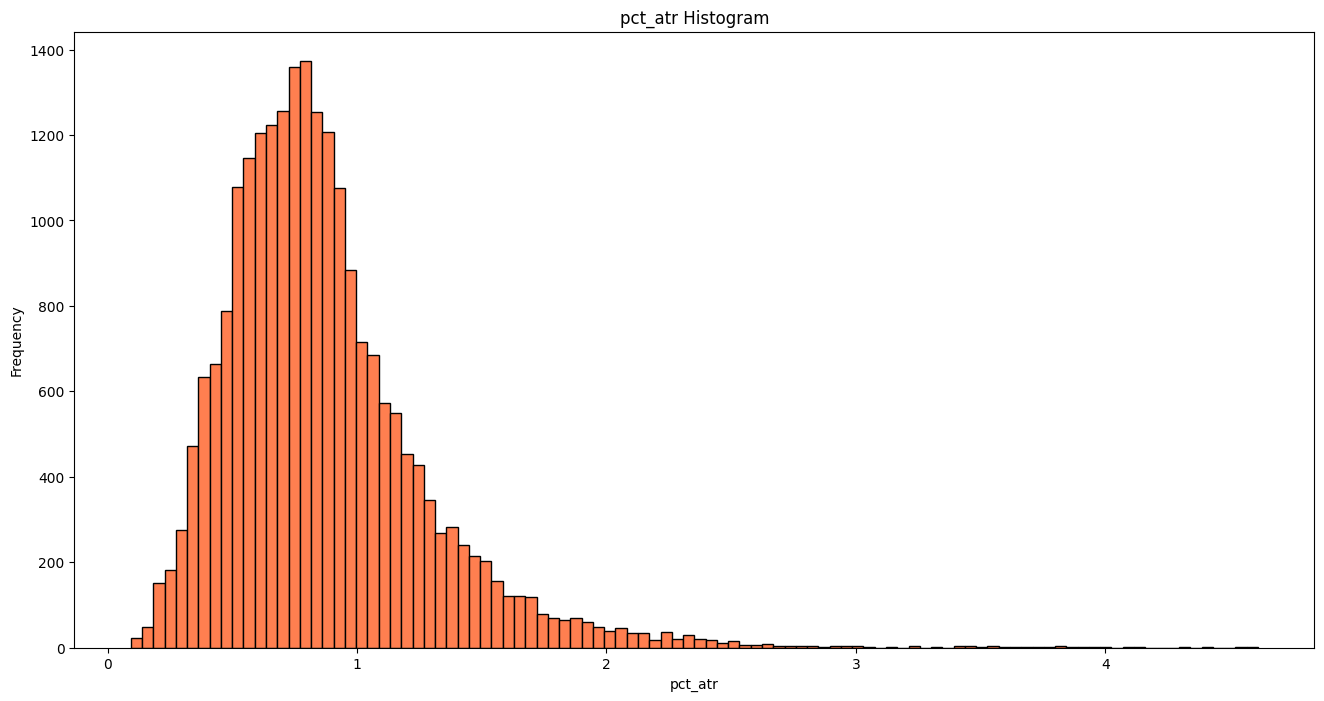

In [ ]:
plt.figure(figsize=(16, 8))
plt.hist(df['pct_atr'], bins=100, color='coral', edgecolor='black')

plt.title('pct_atr Histogram')
plt.xlabel('pct_atr')
plt.ylabel('Frequency')
plt.show()


In [ ]:
df['pct_atr'].quantile(0.05)

np.float64(0.3614791772463592)

In [ ]:
len(df[(df['pct_atr'] > df['pct_atr'].quantile(0.9)) & (df['bb_3_touch_short_clean'])])

35

In [ ]:
# It determined according to percent atr levels.
df['x'] = np.minimum(
    np.maximum(df['close'] * df['pct_atr'].quantile(0.05)/100, 1 * df['atr']),
    df['close'] * df['pct_atr'].quantile(0.9)/100
)

x_levels = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]

for level in x_levels:
    df[f'target_{level}x'] = df['close'] + level * df['x']


In [ ]:
df.iloc[-5:, :5]

,time,open,high,low,close
22573,2025-07-29 18:00:00+03:00,3782.2500000000,3783.5000000000,3747.0000000000,3761.5700000000
22574,2025-07-29 19:00:00+03:00,3761.5600000000,3769.1600000000,3716.0400000000,3751.4500000000
22575,2025-07-29 20:00:00+03:00,3751.4500000000,3793.5900000000,3744.5200000000,3769.7400000000
22576,2025-07-29 21:00:00+03:00,3769.7300000000,3776.5700000000,3752.4800000000,3770.9900000000
22577,2025-07-29 22:00:00+03:00,3771.0000000000,3773.1700000000,3768.5300000000,3771.6100000000


In [ ]:
df.iloc[-5:, -35:-25]

,macd_long_signal,macd_short_signal,stoch_long_signal,stoch_short_signal,two_dots_long,two_dots_short,bb_touch_upper,bb_touch_lower,bb_1_touch_long,bb_1_touch_short
22573,False,False,False,True,False,False,False,False,False,False
22574,False,False,False,False,False,False,False,True,False,False
22575,False,False,False,False,False,False,False,False,False,False
22576,False,False,False,False,False,False,False,False,False,False
22577,False,False,False,False,False,False,False,False,False,False


# Target and Results

In [ ]:
def calculate_bars_to_hit_updated(df, max_bars=100, verbose=True):
    for i in range(len(df)):
        entry = df.loc[i, 'close']
        x = df.loc[i, 'x']
        for level in x_levels:
            target_price = entry + level * x
            for j in range(1, max_bars + 1):
                if i + j >= len(df):
                    break
                high = df.loc[i + j, 'high']
                low = df.loc[i + j, 'low']
                if (level > 0 and high >= target_price) or (level < 0 and low <= target_price):
                    df.at[i, f'{level}x_bar'] = j
                    break

    # Inform per 1000 rows.
        if verbose and i % 1000 == 0 and i != 0:
            print(f"{i} satır tamamlandı...")

    return df


In [ ]:
#x_levels = [ -2, -1, 1, 2 ]
#x_levels = [ -3, -1, 1, 3 ]
#x_levels = [ -4, -1,  2,  4 ]
x_levels = [ -4, -3, -2, -1, 1, 2, 3, 4 ]
#x_levels = [ -5, -4, -3, -2, -1, 1, 2, 3, 4, 5 ]
df = calculate_bars_to_hit_updated(df)


1000 satır tamamlandı...
2000 satır tamamlandı...
3000 satır tamamlandı...
4000 satır tamamlandı...
5000 satır tamamlandı...
6000 satır tamamlandı...
7000 satır tamamlandı...
8000 satır tamamlandı...
9000 satır tamamlandı...
10000 satır tamamlandı...
11000 satır tamamlandı...
12000 satır tamamlandı...
13000 satır tamamlandı...
14000 satır tamamlandı...
15000 satır tamamlandı...
16000 satır tamamlandı...
17000 satır tamamlandı...
18000 satır tamamlandı...
19000 satır tamamlandı...
20000 satır tamamlandı...
21000 satır tamamlandı...
22000 satır tamamlandı...


In [ ]:
df.tail()

,time,open,high,low,close,volume,histogram,macd,signal,atr,rsi,cat_rsi,rsi_40,bb_middle,bb_upper,bb_lower,dc_upper_20,dc_lower_20,dc_middle_20,dc_upper_50,dc_lower_50,dc_middle_50,sma_50,sma_200,sma_200_4h,sma_50_rate,trend_13_50,trend_50_200,trend_4h_50_200,ema,ema_20,ema_50_rate,ema_20_rate,nw,nw_upper,nw_lower,supertrend,supertrend_direction,supertrend_signal,stoch_k,stoch_d,stoch_rsi_k,stoch_rsi_d,macd_line,macd_signal,macd_hist,candle,candle_body,candle_strength,candle_class,volume_price,volume_candle,prev_close,high_low,high_prev_close,low_prev_close,tr,prev_high,prev_low,up_move,down_move,+dm,-dm,tr_ema,+dm_ema,-dm_ema,+di,-di,dx,adx,obv,dc_position_ratio_20,dc_position_20,dc_position_ratio_50,dc_position_50,dc_breakout_20,dc_breakdown_20,dc_breakout_50,dc_breakdown_50,bb_position,stoch_position,stoch_cross_up,stoch_cross_down,nw_position,adx_category,diff_50_200,diff_50_200_prev,sma_cross_up,sma_cross_down,diff_50_200_4h,diff_50_200_4h_prev,sma_cross_up_4h,sma_cross_down_4h,pct_atr,macd_long_signal,macd_short_signal,stoch_long_signal,stoch_short_signal,two_dots_long,two_dots_short,bb_touch_upper,bb_touch_lower,bb_1_touch_long,bb_1_touch_short,bb_3_touch_long,bb_3_touch_short,nw_long,nw_short,bb_3_touch_long_clean,bb_3_touch_short_clean,bb_1_touch_long_clean,bb_1_touch_short_clean,dc_breakout_clean_20,dc_breakdown_clean_20,dc_breakout_clean_50,dc_breakdown_clean_50,nw_long_clean,nw_short_clean,x,target_-5x,target_-4x,target_-3x,target_-2x,target_-1x,target_1x,target_2x,target_3x,target_4x,target_5x,1x_bar,2x_bar,3x_bar,4x_bar,-1x_bar,-2x_bar,-3x_bar,-4x_bar
22573,2025-07-29 18:00:00+03:00,3782.2500000000,3783.5000000000,3747.0000000000,3761.5700000000,42823.3068000000,-2.9193689754,3.5171521088,6.4365210842,38.8082878696,50.4268079840,above_avg,42.1834999929,3809.0810000000,3885.9936796471,3732.1683203529,3886.4400000000,3731.2100000000,3808.8250000000,3941.0000000000,3731.2100000000,3836.1050000000,3833.6370000000,3737.5102000000,3058.7481000000,0.9812014022,downtrend,uptrend,uptrend,3814.1260926340,3817.4392961230,0.9862206725,0.9853647192,3820.0183898629,3917.7887502748,3722.2480294510,3758.2240000000,uptrend,0.0000000000,37.1810780845,37.4628416653,49.5844940093,47.3323971860,3.5171521088,6.4365210841,-2.9193689754,red,20.6800000000,0.5328758658,weak_bearish,11.3844237380,235.4298829010,3782.2600000000,36.5000000000,1.2400000000,35.2600000000,36.5000000000,3840.2600000000,3770.0000000000,-56.7600000000,23.0000000000,0.0000000000,23.0000000000,40.8198403555,7.5547012099,15.1241699818,18.5074246840,37.0510267803,33.3767439653,27.6471305105,-2000457.2536000011,19.5580751143,0-25,14.4716144716,0-25,False,False,False,False,0-25,low,False,True,below_middle,medium_trend,96.1268000000,96.9662000000,False,False,678.7621000000,96.9662000000,False,False,1.0317045242,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,38.8082878696,3567.5285606520,3606.3368485216,3645.1451363912,3683.9534242608,3722.7617121304,3800.3782878696,3839.1865757392,3877.9948636088,3916.8031514784,3955.6114393480,NaN,NaN,NaN,NaN,1.0000000000,NaN,NaN,NaN
22574,2025-07-29 19:00:00+03:00,3761.5600000000,3769.1600000000,3716.0400000000,3751.4500000000,53294.9354000000,-5.1832405549,-0.0425296095,5.1407109454,39.8305530218,48.8184615385,below_avg,42.1817101802,3807.2510000000,3887.9205175977,3726.5814824023,3886.4400000000,3716.0400000000,3801.2400000000,3941.0000000000,3716.0400000000,3828.5200000000,3832.4772000000,3737.3797000000,3060.3289125000,0.9788577477,downtrend,uptrend,uptrend,3811.6682066484,3811.1546012541,0.9842016137,0.9843342484,3813.6012833376,3913.9641993867,3713.2383672886,3867.3820000000,downtrend,1.0000000000,36.1219649265,37.3218392601,47.2233276279,47.3187634913,-0.0425296095,5.1407109454,-5.1832405549,red,10.1100000000,0.2538252480,weak_bearish,14.2064895974,143.6276098293,3761.5700000000,53.1200000000,7.5900000000,45.5300000000,53.1200000000,37

In [ ]:
x_levels = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
df = df[
    [col for col in df.columns if 'x_bar' not in col] +
    [f"{i}x_bar" for i in x_levels if f"{i}x_bar" in df.columns]
]

In [ ]:
len(df)

22578

In [ ]:
df.iloc[-110:-90, -15:]

,target_-2x,target_-1x,target_1x,target_2x,target_3x,target_4x,target_5x,-4x_bar,-3x_bar,-2x_bar,-1x_bar,1x_bar,2x_bar,3x_bar,4x_bar
22468,3534.3232755005,3582.9666377502,3680.2533622498,3728.8967244995,3777.5400867493,3826.1834489990,3874.8268112488,NaN,NaN,NaN,NaN,3.0000000000,3.0000000000,26.0000000000,52.0000000000
22469,3532.9752449259,3582.3226224629,3681.0173775371,3730.3647550741,3779.7121326112,3829.0595101483,3878.4068876853,NaN,NaN,NaN,NaN,2.0000000000,2.0000000000,27.0000000000,51.0000000000
22470,3565.2243560426,3615.0221780213,3714.6178219787,3764.4156439574,3814.2134659361,3864.0112879148,3913.8091098935,NaN,NaN,NaN,7.0000000000,1.0000000000,18.0000000000,50.0000000000,58.0000000000
22471,3624.8195459977,3675.4497729988,3776.7102270012,3827.3404540023,3877.9706810035,3928.6009080047,3979.2311350058,NaN,NaN,5.0000000000,5.0000000000,23.0000000000,49.0000000000,61.0000000000,68.0000000000
22472,3617.8249424101,3668.3574712050,3769.4225287950,3819.9550575899,3870.4875863849,3921.0201151799,3971.5526439749,NaN,NaN,5.0000000000,4.0000000000,22.0000000000,48.0000000000,60.0000000000,67.0000000000
22473,3621.5851851543,3671.4775925771,3771.2624074229,3821.1548148457,3871.0472222686,3920.9396296915,3970.8320371143,NaN,NaN,3.0000000000,3.0000000000,21.0000000000,47.0000000000,59.0000000000,66.0000000000
22474,3605.9398147861,3655.1949073930,3753.7050926070,3802.9601852139,3852.2152778209,3901.4703704278,3950.7254630348,NaN,NaN,3.0000000000,2.0000000000,14.0000000000,41.0000000000,54.0000000000,62.0000000000
22475,3608.3262565871,3657.1781282935,3754.8818717065,3803.7337434129,3852.5856151194,3901.4374868258,3950.2893585323,NaN,NaN,2.0000000000,1.0000000000,13.0000000000,40.0000000000,53.0000000000,61.0000000000
22476,3530.6015546959,3579.9157773479,3678.5442226521,3727.8584453041,3777.1726679562,3826.4868906083,3875.8011132604,NaN,NaN,NaN,NaN,6.0000000000,8.0000000000,18.0000000000,44.0000000000
22477,3535.4364893037,3584.8182446518,3683.5817553482,3732.9635106963,3782.3452660445,3831.7270213926,3881.1087767408,NaN,NaN,NaN,NaN,5.0000000000,11.0000000000,19.0000000000,43.0000000000


In [ ]:
df.iloc[:,-18:].columns

Index(['target_-5x', 'target_-4x', 'target_-3x', 'target_-2x', 'target_-1x', 'target_1x', 'target_2x', 'target_3x', 'target_4x', 'target_5x', '-4x_bar', '-3x_bar', '-2x_bar', '-1x_bar', '1x_bar', '2x_bar', '3x_bar', '4x_bar'], dtype='object')

#

In [ ]:
def analyze_x_bar_results_transposed_display(df):
    """
    Analyze x_bar columns and return transposed table (horizontal view),
    rounded to 2 decimals, with '%' symbol on percent_reached row.
    """
    x_bar_cols = [col for col in df.columns if col.endswith('x_bar')]
    analysis = pd.DataFrame(columns=["level", "count", "percent_reached", "mean_bar", "median_bar"])

    for col in x_bar_cols:
        level = col.replace("x_bar", "")
        values = df[col].dropna()
        count = len(values)
        percent_reached = (count / len(df)) * 100
        mean_bar = values.mean()
        median_bar = values.median()

        analysis = pd.concat([
            analysis,
            pd.DataFrame([{
                "level": level,
                "count": count,
                "percent_reached": percent_reached,
                "mean_bar": mean_bar,
                "median_bar": median_bar
            }])
        ], ignore_index=True)

    # Doğru sıralama için
    analysis["sort_key"] = analysis["level"].astype(str).str.replace('−', '-').str.replace('–', '-').astype(float)
    analysis = analysis.sort_values("sort_key").drop(columns="sort_key")

    # Transpoze et
    transposed = analysis.set_index("level").T

    # Yüzde satırında % işareti, diğerlerini 2 ondalık
    def format_value(val, row_name):
        if row_name == "percent_reached":
            return f"{val:.2f}%"
        return round(val, 2)

    for row in transposed.index:
        transposed.loc[row] = transposed.loc[row].apply(lambda val: format_value(val, row))

    return transposed




# GENERAL BAR DISTIRIBUTION

In [ ]:
result = analyze_x_bar_results_transposed_display(df)
print(result)



level                      -4            -3            -2            -1             1             2             3             4
count                   11972         14354         17076         19728         19986         17414         15036         12855
percent_reached        53.03%        63.58%        75.63%        87.38%        88.52%        77.13%        66.60%        56.94%
mean_bar        35.9000000000 29.5200000000 22.0900000000 12.8600000000 13.0100000000 22.7600000000 30.5800000000 36.5800000000
median_bar      28.0000000000 21.0000000000 13.0000000000  5.0000000000  6.0000000000 14.0000000000 22.0000000000 30.0000000000


/tmp/ipython-input-2269534140.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  analysis = pd.concat([


In [ ]:
def average_bars_to_levels(df, signal_columns, x_bar_columns):
    """
    Her sinyal için, ulaşılabilen x seviyelerine ortalama ve medyan bar süresini hesaplar.

    Args:
        df (pd.DataFrame): Ana veri seti
        signal_columns (list): ['sinyal_1', 'sinyal_2', ...]
        x_bar_columns (list): ['1x_bar', '2x_bar', ...]

    Returns:
        pd.DataFrame: Sinyal - seviye - ortalama bar - medyan bar tablosu
    """
    results = []

    for signal in signal_columns:
        if signal not in df.columns:
            continue
        df_signal = df[df[signal] == True]

        for x_col in x_bar_columns:
            if x_col not in df.columns:
                continue
            valid = df_signal[x_col].dropna()
            if len(valid) == 0:
                continue

            results.append({
                'signal': signal,
                'x_level': x_col,
                'mean_bar': round(valid.mean(), 2),
                'count': len(valid)
            })

    return pd.DataFrame(results)



In [ ]:
signal_columns = [
    'bb_3_touch_long_clean', 'bb_3_touch_short_clean',
    'bb_1_touch_long_clean', 'bb_1_touch_short_clean',
    'dc_breakout_clean_20', 'dc_breakdown_clean_20',
    'dc_breakout_clean_55', 'dc_breakdown_clean_55',
    'nw_long_clean', 'nw_short_clean'
]

x_bar_cols = [col for col in df.columns if col.endswith('x_bar')]

avg_bar_df = average_bars_to_levels(df, signal_columns, x_bar_cols)

In [ ]:
avg_bar_df[avg_bar_df['signal']=='bb_3_touch_long_clean'].T

,0,1,2,3,4,5,6,7
signal,bb_3_touch_long_clean,bb_3_touch_long_clean,bb_3_touch_long_clean,bb_3_touch_long_clean,bb_3_touch_long_clean,bb_3_touch_long_clean,bb_3_touch_long_clean,bb_3_touch_long_clean
x_level,-4x_bar,-3x_bar,-2x_bar,-1x_bar,1x_bar,2x_bar,3x_bar,4x_bar
mean_bar,37.1200000000,32.9000000000,22.7300000000,11.2000000000,13.4900000000,20.9200000000,26.8500000000,29.9600000000
count,130,157,183,203,209,181,151,133


In [ ]:
signal_columns = [
    'bb_3_touch_long_clean', 'bb_3_touch_short_clean',
    'bb_1_touch_long_clean', 'bb_1_touch_short_clean',
    'dc_breakout_clean_20', 'dc_breakdown_clean_20',
    'dc_breakout_clean_55', 'dc_breakdown_clean_55',
    'nw_long_clean', 'nw_short_clean'
]
for col in signal_columns:
  print(col.upper())
  print(avg_bar_df[avg_bar_df['signal']==col].T, end='\n\n----------\n\n')


BB_3_TOUCH_LONG_CLEAN
                              0                      1                      2                      3                      4                      5                      6                      7
signal    bb_3_touch_long_clean  bb_3_touch_long_clean  bb_3_touch_long_clean  bb_3_touch_long_clean  bb_3_touch_long_clean  bb_3_touch_long_clean  bb_3_touch_long_clean  bb_3_touch_long_clean
x_level                 -4x_bar                -3x_bar                -2x_bar                -1x_bar                 1x_bar                 2x_bar                 3x_bar                 4x_bar
mean_bar          37.1200000000          32.9000000000          22.7300000000          11.2000000000          13.4900000000          20.9200000000          26.8500000000          29.9600000000
count                       130                    157                    183                    203                    209                    181                    151                    133

----------



# Dataframe Columns

In [ ]:
print(df.tail(10))

                           time            open            high             low           close           volume     histogram          macd       signal           atr           rsi    cat_rsi        rsi_40       bb_middle        bb_upper        bb_lower     dc_upper_20     dc_lower_20    dc_middle_20     dc_upper_50     dc_lower_50    dc_middle_50          sma_50         sma_200      sma_200_4h  sma_50_rate trend_13_50 trend_50_200 trend_4h_50_200             ema          ema_20  ema_50_rate  ema_20_rate              nw        nw_upper        nw_lower      supertrend supertrend_direction  supertrend_signal       stoch_k       stoch_d   stoch_rsi_k   stoch_rsi_d     macd_line  macd_signal     macd_hist candle   candle_body  candle_strength    candle_class  volume_price  volume_candle      prev_close      high_low  high_prev_close  low_prev_close            tr       prev_high        prev_low        up_move      down_move           +dm           -dm        tr_ema       +dm_ema       -dm_

In [ ]:
print(df[df['bb_3_touch_long_clean']])

                           time            open            high             low           close           volume     histogram          macd         signal           atr           rsi     cat_rsi        rsi_40       bb_middle        bb_upper        bb_lower     dc_upper_20     dc_lower_20    dc_middle_20     dc_upper_50     dc_lower_50    dc_middle_50          sma_50         sma_200      sma_200_4h  sma_50_rate trend_13_50 trend_50_200 trend_4h_50_200             ema          ema_20  ema_50_rate  ema_20_rate              nw        nw_upper        nw_lower      supertrend supertrend_direction  supertrend_signal       stoch_k       stoch_d   stoch_rsi_k   stoch_rsi_d     macd_line    macd_signal     macd_hist candle   candle_body  candle_strength    candle_class  volume_price  volume_candle      prev_close      high_low  high_prev_close  low_prev_close            tr       prev_high        prev_low        up_move      down_move          +dm           -dm        tr_ema       +dm_ema       

* Analizde NAN değerleri doldurmak için yeni bir df oluşturuyoruz.

# Signal Standard Results

In [ ]:
def compare_x_bars(df, signal_col, x_levels, signal_type='long'):
    """
    Pozitif ve negatif x_bar sütunlarını ikili karşılaştırır. Long/Short destekli.

    Args:
        df (pd.DataFrame): Ana DataFrame
        signal_col (str): Sinyal sütunu adı
        x_levels (list): x seviyeleri (örn: [-10, -5, ..., 10])
        signal_type (str): 'long' veya 'short'

    Returns:
        pd.DataFrame: Sonuç tablosu
    """
    results = []
    df_signal = df[df[signal_col] == True].copy()

    pos_x = [x for x in x_levels if x > 0]
    neg_x = [x for x in x_levels if x < 0]

    for px in pos_x:
        for nx in neg_x:
            pos_col = f"{px}x_bar"
            neg_col = f"{nx}x_bar"

            if pos_col in df_signal.columns and neg_col in df_signal.columns:
                df_valid = df_signal.copy()

                mask = (df_valid[pos_col].isna() ^ df_valid[neg_col].isna()) | \
                       (df_valid[pos_col].notna() & df_valid[neg_col].notna())

                df_valid = df_valid[mask]
                df_valid[pos_col] = df_valid[pos_col].fillna(999)
                df_valid[neg_col] = df_valid[neg_col].fillna(999)

                if signal_type == 'long':
                    tp_first = (df_valid[pos_col] < df_valid[neg_col]).sum()
                    sl_first = (df_valid[pos_col] > df_valid[neg_col]).sum()
                    profit_score = ((tp_first * px + sl_first * nx) / len(df_valid)) * 100 if len(df_valid) > 0 else 0.0

                    results.append({
                        "tp_level": f"{px}x_bar",
                        "sl_level": f"{nx}x_bar",
                        "tp_first": tp_first,
                        "sl_first": sl_first,
                        "total": len(df_valid),
                        "tp_rate": round((tp_first / len(df_valid)) * 100, 2),
                        "sl_rate": round((sl_first / len(df_valid)) * 100, 2),
                        "profit_score": round(profit_score, 2)
                    })

                elif signal_type == 'short':
                    tp_first = (df_valid[neg_col] < df_valid[pos_col]).sum()
                    sl_first = (df_valid[neg_col] > df_valid[pos_col]).sum()
                    profit_score = -((tp_first * nx + sl_first * px) / len(df_valid)) * 100 if len(df_valid) > 0 else 0.0

                    results.append({
                        "tp_level": f"{nx}x_bar",  # TP seviyesi negatif olmalı
                        "sl_level": f"{px}x_bar",  # SL seviyesi pozitif olmalı
                        "tp_first": tp_first,
                        "sl_first": sl_first,
                        "total": len(df_valid),
                        "tp_rate": round((tp_first / len(df_valid)) * 100, 2),
                        "sl_rate": round((sl_first / len(df_valid)) * 100, 2),
                        "profit_score": round(profit_score, 2)
                    })

    return pd.DataFrame(results)


# 6 Aylık başlangıç, bitiş, min ve max değerler

In [ ]:
print('Start:', df.loc[df['time']==df['time'].min(), 'close'])
print('Finish:', df.loc[df['time']==df['time'].max(), 'close'])
print('Min:', df['close'].min())
print('Max:', df['close'].max())

Start: 0   1194.0900000000
Name: close, dtype: float64
Finish: 22577   3771.6100000000
Name: close, dtype: float64
Min: 1192.92
Max: 4086.66


In [ ]:
df['candle_strength'].describe([0.05, 0.1, 0.9, 0.95])

,candle_strength
count,22578.0000000000
mean,0.4629745583
std,0.4612583525
min,0.0000000000
5%,0.0306454148
10%,0.0640138766
50%,0.3374864907
90%,0.9908488933
95%,1.3265073766
max,6.5368092879


In [ ]:
df['volume_price'].describe([0.05, 0.1, 0.9, 0.95])

,volume_price
count,22578.0000000000
mean,8.0073875009
std,9.7337642171
min,0.1756695682
5%,1.5523874111
10%,1.9997761672
50%,5.2843713999
90%,16.1528675111
95%,23.1703567997
max,257.3817576886


In [ ]:
df['obv'].describe([0.01, 0.05, 0.1, 0.9, 0.95, 0.99])

,obv
count,22578.0000000000
mean,-938891.5589357086
std,1555989.9237289049
min,-5120540.7223999966
1%,-4682238.9582289960
5%,-3935556.5942849959
10%,-3346625.5883099986
50%,-825588.5897999961
90%,805975.3224799995
95%,1163953.8122150020


In [ ]:
df['time'].min()

Timestamp('2023-01-01 03:00:00+0300', tz='UTC+03:00')

# BIG TIME INTERVAL

In [ ]:
#df_4h = pd.read_csv('/content/ARB_big_time_4h.csv')
#df_4h['time'] = pd.to_datetime(df_4h['time'])

In [ ]:
#df_4h = df_4h.drop('Unnamed: 0',axis=1)
#df_4h = df_4h[df_4h['time'] >= df['time'].min()]
#df_4h.head()

In [ ]:
#df.set_index('time', inplace=True)
#df_4h.set_index('time', inplace=True)
#df_4h.index = df_4h.index + pd.Timedelta(hours=4)

#df_4h.columns = [col + '_4h' for col in df_4h.columns]

In [ ]:
#df = pd.merge_asof(df,df_4h, left_index=True,right_index=True,direction='backward')

In [ ]:
dff = df.copy()

dff.loc[:, dff.columns.str.contains('x_bar')] = dff.loc[:, dff.columns.str.contains('x_bar')].fillna(999)
#dff.tail()

# GENERAL DATAFRAME ANALYSIS

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   ['pct_atr', 'x','sma_50_rate', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle', 'adx', 'obv','volume']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   ['pct_atr', 'x','sma_50_rate' ,'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle', 'adx', 'obv','volume']].mean().rename('SL')], axis=1)

,TP,SL
pct_atr,0.8754010540,0.8593496145
x,20.8200593951,21.0363372155
sma_50_rate,1.0024930889,1.0011958619
rsi,51.5838283649,50.6261055545
macd_line,3.1062001842,1.3483315275
macd_signal,3.1318324893,1.3273923875
macd_hist,-0.0256323050,0.0209391400
stoch_k,53.6157592765,53.1629692399
stoch_d,53.6491798861,53.1480325734
stoch_rsi_k,50.1626346986,50.4284572178


In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) ,
                   ['pct_atr', 'x','sma_50_rate','rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle', 'adx', 'obv','volume']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) ,
                   ['pct_atr', 'x','sma_50_rate', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle', 'adx', 'obv','volume']].mean().rename('SL')], axis=1)

,TP,SL
pct_atr,0.83,0.88
x,20.55,21.20
sma_50_rate,1.00,1.00
rsi,50.10,51.06
macd_line,-0.12,2.47
macd_signal,-0.18,2.51
macd_hist,0.06,-0.04
stoch_k,52.06,53.79
stoch_d,51.93,53.85
stoch_rsi_k,50.62,50.21


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'adx_category'].value_counts().rename('SL')]
          , axis=1).reindex(['weak_trend', 'medium_trend' ,'strong_trend', 'super_strong_trend'])

,TP,SL
adx_category,,
weak_trend,1059,4625
medium_trend,1966,7439
strong_trend,1209,4473
super_strong_trend,333,1316


In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) ,
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) ,
                   'adx_category'].value_counts().rename('SL')]
          , axis=1).reindex(['weak_trend', 'medium_trend' ,'strong_trend', 'super_strong_trend' ])

,TP,SL
adx_category,,
weak_trend,1879,3754
medium_trend,3034,6254
strong_trend,1748,3855
super_strong_trend,529,1051


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'candle'].value_counts().rename('SL')],axis=1)

,TP,SL
candle,,
green,2350,9052
red,2228,8803


In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']),
                   'candle'].value_counts().rename('SL')],axis=1)

,TP,SL
candle,,
red,3613,7270
green,3577,7657


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'candle_class'].value_counts().rename('SL')],axis=1)

,TP,SL
candle_class,,
weak_bullish,1862,7289
weak_bearish,1788,7034
medium_bullish,309,1077
medium_bearish,266,1043
strong_bullish,179,686
strong_bearish,174,726


In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']),
                   'candle_class'].value_counts().rename('SL')],axis=1)

,TP,SL
candle_class,,
weak_bearish,2909,5783
weak_bullish,2848,6185
medium_bullish,455,898
medium_bearish,405,894
strong_bearish,299,593
strong_bullish,274,574


In [ ]:
pd.concat([dff.loc[(dff['1x_bar'] < dff['-1x_bar']) & (dff['sma_50_rate'] > 1.12),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['1x_bar'] > dff['-1x_bar']) & (dff['sma_50_rate'] > 1.12),
                   'candle_class'].value_counts().rename('SL')],axis=1).fillna(0)

,TP,SL
candle_class,,
weak_bearish,13,3
weak_bullish,9,7
strong_bullish,7,1
medium_bullish,3,2
strong_bearish,1,1


In [ ]:
pd.concat([dff.loc[(dff['-1x_bar'] < dff['1x_bar']) & (dff['sma_50_rate'] < 0.90),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-1x_bar'] > dff['1x_bar']) & (dff['sma_50_rate'] < 0.90),
                   'candle_class'].value_counts().rename('SL')],axis=1).fillna(0)

,TP,SL
candle_class,,
weak_bearish,8.00,14
weak_bullish,8.00,7
medium_bearish,4.00,3
strong_bearish,3.00,4
medium_bullish,3.00,2
strong_bullish,0.00,1


In [ ]:
dff[(dff['sma_50_rate'] > 1.12) & (dff['sma_50_rate'].shift(1) < 1.12)][['-2x_bar','1x_bar']]

,-2x_bar,1x_bar
12138,999.00,1.00
16224,4.00,19.00
19003,4.00,999.00
20609,999.00,1.00
20631,999.00,14.00


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['rsi'] > 70) & (dff['trend_50_200']=='uptrend'),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['rsi'] > 70) & (dff['trend_50_200']=='uptrend'),
                   'adx_category'].value_counts().rename('SL')],axis=1)

,TP,SL
adx_category,,
strong_trend,178,560
super_strong_trend,121,357
medium_trend,98,347
weak_trend,24,71


In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar'])  & (dff['rsi'] < 30) & (dff['trend_50_200']=='downtrend'),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar'])  & (dff['rsi'] < 30) & (dff['trend_50_200']=='downtrend'),
                   'adx_category'].value_counts().rename('SL')],axis=1)

,TP,SL
adx_category,,
super_strong_trend,187,224
strong_trend,164,326
medium_trend,98,219
weak_trend,31,38


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar'])  & (dff['sma_50_rate'] > 1.10),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar'])  & (dff['sma_50_rate'] > 1.10),
                   'adx_category'].value_counts().rename('SL')],axis=1)

,TP,SL
adx_category,,
super_strong_trend,26.00,28
strong_trend,8.00,8
medium_trend,NaN,2


In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar'])  & (dff['sma_50_rate'] < 0.92),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar'])  & (dff['sma_50_rate'] < 0.92),
                   'adx_category'].value_counts().rename('SL')],axis=1)

,TP,SL
adx_category,,
super_strong_trend,40,68
strong_trend,7,42
medium_trend,2,6


In [ ]:
pd.concat([
    dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75'])) & (dff['sma_50_rate'] > 1.1)].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75'])) & (dff['sma_50_rate'] > 1.1)].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0)

,TP_Count,SL_Count
candle_class,,
strong_bullish,1.00,0.00
weak_bearish,1.00,1.00
weak_bullish,0.00,1.00


In [ ]:
pd.concat([
    dff[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0)

,TP_Count,SL_Count
candle_class,,
medium_bearish,1.00,10
medium_bullish,5.00,13
strong_bearish,6.00,5
weak_bearish,27.00,42
weak_bullish,24.00,57
strong_bullish,0.00,4


In [ ]:
pd.concat([
    dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0)

In [ ]:
pd.concat([
    dff[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0)

In [ ]:
df['sma_50_rate'].max(), df['sma_50_rate'].min()

In [ ]:
df.head(20)

In [ ]:
dff[(dff['sma_50_rate'] < 0.90) & (dff['sma_50_rate'].shift(1) > 0.90) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

###SMA_RATE

In [ ]:
df['sma_50_rate'].max(), df['sma_50_rate'].min()

(1.2179827002520185, 0.7970222973959269)

In [ ]:
dff[(dff['sma_50_rate'] < 0.92) & (dff['sma_50_rate'].shift(1) > 0.92) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

np.int64(18)

In [ ]:
dff[(dff['sma_50_rate'] < 0.92) & (dff['sma_50_rate'].shift(1) > 0.92) & (dff['1x_bar'] > dff['-1x_bar'])]['open'].count()

np.int64(15)

In [ ]:
dff[(dff['sma_50_rate'] > 1.08) & (dff['sma_50_rate'].shift(1) < 1.08) & (dff['1x_bar'] > dff['-1x_bar'])]['open'].count()

np.int64(15)

In [ ]:
dff[(dff['sma_50_rate'] > 1.08) & (dff['sma_50_rate'].shift(1) < 1.08) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

np.int64(18)

In [ ]:
dff[(dff['sma_50_rate'] < 0.92) & (dff['sma_50_rate'].shift(1) > 0.92) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count()

np.int64(14)

In [ ]:
dff[(dff['sma_50_rate'] < 0.92) & (dff['sma_50_rate'].shift(1) > 0.92) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] > 1.08) & (dff['sma_50_rate'].shift(1) < 1.08) & (dff['1x_bar'] > dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] > 1.08) & (dff['sma_50_rate'].shift(1) < 1.08) & (dff['1x_bar'] < dff['-2x_bar'])]['open'].count()

###EMA_RATE

In [ ]:
df['ema_50_rate'].max(), df['ema_50_rate'].min()

In [ ]:
dff[(dff['ema_50_rate'] < 0.93) & (dff['ema_50_rate'].shift(1) > 0.93) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] < 0.93) & (dff['ema_50_rate'].shift(1) > 0.93) & (dff['1x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] > 1.07) & (dff['ema_50_rate'].shift(1) < 1.07) & (dff['1x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] > 1.07) & (dff['ema_50_rate'].shift(1) < 1.07) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] < 0.93) & (dff['ema_50_rate'].shift(1) > 0.93) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] < 0.93) & (dff['ema_50_rate'].shift(1) > 0.93) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] > 1.07) & (dff['ema_50_rate'].shift(1) < 1.07) & (dff['1x_bar'] > dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] > 1.07) & (dff['ema_50_rate'].shift(1) < 1.07) & (dff['1x_bar'] < dff['-2x_bar'])]['open'].count()

In [ ]:
df['ema_20_rate'].max(), df['ema_20_rate'].min()

In [ ]:
dff[(dff['ema_20_rate'] < 0.94) & (dff['ema_20_rate'].shift(1) > 0.94) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] < 0.94) & (dff['ema_20_rate'].shift(1) > 0.94) & (dff['1x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] > 1.06) & (dff['ema_20_rate'].shift(1) < 1.06) & (dff['1x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] > 1.06) & (dff['ema_20_rate'].shift(1) < 1.06) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] < 0.94) & (dff['ema_20_rate'].shift(1) > 0.94) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] < 0.94) & (dff['ema_20_rate'].shift(1) > 0.94) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] > 1.06) & (dff['ema_20_rate'].shift(1) < 1.06) & (dff['1x_bar'] > dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] > 1.06) & (dff['ema_20_rate'].shift(1) < 1.06) & (dff['1x_bar'] < dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] < 0.94) & (dff['ema_20_rate'].shift(1) > 0.94)].index

In [ ]:
dff[(dff['ema_50_rate'] < 0.91) & (dff['ema_50_rate'].shift(1) > 0.91)].index

In [ ]:
dff[(dff['sma_50_rate'] < 0.90) & (dff['sma_50_rate'].shift(1) > 0.90)].index

In [ ]:
dff[(dff['ema_20_rate'] > 1.06) & (dff['ema_20_rate'].shift(1) < 1.06)].index

In [ ]:
dff[(dff['ema_50_rate'] > 1.1) & (dff['ema_50_rate'].shift(1) < 1.1)].index

In [ ]:
dff[(dff['sma_50_rate'] > 1.1) & (dff['sma_50_rate'].shift(1) < 1.1)].index

### SMA CROSS

In [ ]:
dff[(dff['close'] > dff['sma_50']) & (dff['sma_cross_up']) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count(),dff[(dff['close'] > dff['sma_50']) & (dff['sma_cross_up']) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['close'] < dff['sma_50']) & (dff['sma_cross_down']) & (dff['-2x_bar'] < dff['1x_bar'])]['open'].count(),dff[(dff['close'] < dff['sma_50']) & (dff['sma_cross_down']) & (dff['-2x_bar'] > dff['1x_bar'])]['open'].count()

### SMA CROSS NEGATIVE CLOSE

In [ ]:
dff[(dff['close'] < dff['sma_50']) & (dff['sma_cross_up']) & (dff['-2x_bar'] < dff['1x_bar'])]['open'].count(),dff[(dff['close'] < dff['sma_50']) & (dff['sma_cross_up']) & (dff['-2x_bar'] > dff['1x_bar'])]['open'].count()

In [ ]:
dff[(dff['close'] > dff['sma_50']) & (dff['sma_cross_down']) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count(),dff[(dff['close'] > dff['sma_50']) & (dff['sma_cross_down']) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] > 1.01) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count(),dff[(dff['sma_50_rate'] > 1.01) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

# HIGHEST ATRs

In [ ]:
dff['pct_atr'].describe()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['rsi'] > 80) & (dff['2x_bar'] < dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['rsi'] > 80) & (dff['2x_bar'] > dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['rsi'] < 20) & (dff['2x_bar'] < dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['rsi'] < 20) & (dff['2x_bar'] > dff['-2x_bar'])]['open'].count()

# RSI CROSS UP DOWN

In [ ]:
dff[(dff['rsi'] > 90) & (dff['rsi'].shift(1) < 90) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count(), \
dff[(dff['rsi'] > 90) & (dff['rsi'].shift(1) < 90) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

(np.int64(16), np.int64(26))

In [ ]:
dff[(dff['rsi'] < 10) & (dff['rsi'].shift(1) > 10) & (dff['-2x_bar'] < dff['1x_bar'])]['open'].count(), \
dff[(dff['rsi'] < 10) & (dff['rsi'].shift(1) > 10) & (dff['-2x_bar'] > dff['1x_bar'])]['open'].count()

(np.int64(13), np.int64(24))

In [ ]:
dff[(dff['rsi'] > 85) & (dff['rsi'].shift(1) < 85) & (dff['2x_bar'] < dff['-2x_bar'])]['open'].count(), \
dff[(dff['rsi'] > 85) & (dff['rsi'].shift(1) < 85) & (dff['2x_bar'] > dff['-2x_bar'])]['open'].count()

(np.int64(71), np.int64(62))

In [ ]:
dff[(dff['rsi'] < 15) & (dff['rsi'].shift(1) > 15) & (dff['-2x_bar'] < dff['2x_bar'])]['open'].count(), \
dff[(dff['rsi'] < 15) & (dff['rsi'].shift(1) > 15) & (dff['-2x_bar'] > dff['2x_bar'])]['open'].count()

(np.int64(50), np.int64(44))

# rsi_40

In [ ]:
dff[(dff['rsi_40'] > 75) & (dff['rsi_40'].shift(1) > 75) & (dff['2x_bar'] < dff['-2x_bar'])]['open'].count(), \
dff[(dff['rsi_40'] > 75) & (dff['rsi_40'].shift(1) > 75) & (dff['2x_bar'] > dff['-2x_bar'])]['open'].count()

(np.int64(90), np.int64(86))

In [ ]:
dff[(dff['rsi_40'] < 25) & (dff['rsi_40'].shift(1) < 25) & (dff['-2x_bar'] < dff['2x_bar'])]['open'].count(), \
dff[(dff['rsi_40'] < 25) & (dff['rsi_40'].shift(1) < 25) & (dff['-2x_bar'] > dff['2x_bar'])]['open'].count()

(np.int64(46), np.int64(61))

In [ ]:
dff[ (dff['sma_50_rate'] > 1.05) & (dff['4x_bar'] < dff['-1x_bar'])]['open'].count(), \
dff[(dff['sma_50_rate'] > 1.05) & (dff['4x_bar'] > dff['-1x_bar'])]['open'].count()


In [ ]:
dff[(dff['bb_3_touch_long_clean']) & (dff['sma_50_rate'] < 1.00) & (dff['4x_bar'] < dff['-1x_bar'])]['open'].count(), \
dff[(dff['bb_3_touch_long_clean']) & (dff['sma_50_rate'] < 1.00) & (dff['4x_bar'] > dff['-1x_bar'])]['open'].count()


In [ ]:
dff[(dff['bb_3_touch_short_clean']) & (dff['sma_50_rate'] < 1.00) & (dff['-4x_bar'] < dff['1x_bar'])]['open'].count(), \
dff[(dff['bb_3_touch_short_clean']) & (dff['sma_50_rate'] < 1.00) & (dff['-4x_bar'] > dff['1x_bar'])]['open'].count()


In [ ]:
dff[(dff['bb_3_touch_short_clean']) & (dff['sma_50_rate'] > 1.00) & (dff['-4x_bar'] < dff['1x_bar'])]['open'].count(), \
dff[(dff['bb_3_touch_short_clean']) & (dff['sma_50_rate'] > 1.00) & (dff['-4x_bar'] > dff['1x_bar'])]['open'].count()


# CODE EXIT

In [ ]:
print("Kod çalışması burada durduruluyor.")
raise SystemExit

## CANDLE CLASS

In [ ]:
pd.concat([
    dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']) & (dff['rsi'] > 60) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']) & (dff['rsi'] > 60) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'], fill_value=0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']) & (dff['rsi'] < 60) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']) & (dff['rsi'] < 60) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'], fill_value=0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'], fill_value=0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']) & (dff['rsi'] < 50) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']) & (dff['rsi'] < 50) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'], fill_value=0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['candle_class']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['candle_class']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['cat_rsi']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['cat_rsi']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['cat_rsi']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['cat_rsi']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['dc_position_50']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['dc_position_50']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['dc_position_50']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['dc_position_50']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['dc_position_20']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['dc_position_20']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['dc_position_20']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['dc_position_20']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['bb_position']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['bb_position']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['bb_position']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['bb_position']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['nw_position']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['nw_position']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['nw_position']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['nw_position']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([dff.loc[
        (dff['4x_bar'] < dff['-1x_bar']) &
        (dff['nw_position'].isin(['above_middle'])) &
        (dff['bb_position'].isin(['50-75','75-100','upper_100'])) &
        (dff['dc_position_20'].isin(['75-100', '60-75'])) &
        (dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['overbought', 'above_avg'])),
        ['candle','candle_class']].value_counts().rename('TP')
        , dff.loc[
        (dff['4x_bar'] > dff['-1x_bar']) &
        (dff['nw_position'].isin(['above_middle'])) &
        (dff['bb_position'].isin(['50-75','75-100','upper_100'])) &
        (dff['dc_position_20'].isin(['75-100', '60-75'])) &
        (dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['overbought', 'above_avg'])),
        ['candle','candle_class']].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[
        (dff['-4x_bar'] < dff['2x_bar']) &
        (dff['nw_position'].isin(['below_middle'])) &
        (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
        (dff['dc_position_20'].isin(['0-25', '25-40'])) &
        (dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])),
        ['candle','candle_class']].value_counts().rename('TP')
        , dff.loc[
        (dff['-4x_bar'] > dff['2x_bar']) &
        (dff['nw_position'].isin(['below_middle'])) &
        (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
        (dff['dc_position_20'].isin(['0-25', '25-40'])) &
        (dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])),
        ['candle','candle_class']].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['close'] > dff['sma_50'])].count().rename('TP')[0:1],
    dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['close'] > dff['sma_50'])].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['close'] > dff['sma_200'])].count().rename('TP')[0:1],
    dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['close'] > dff['sma_200'])].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['close'] > dff['sma_50'])].count().rename('TP')[0:1],
    dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['close'] > dff['sma_50'])].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['close'] > dff['sma_200'])].count().rename('TP')[0:1],
    dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['close'] > dff['sma_200'])].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['macd_hist'] > 0)].count().rename('TP')[0:1],
    dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['macd_hist'] > 0)].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['macd_hist'] < 0)].count().rename('TP')[0:1],
    dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['macd_hist'] < 0)].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['macd_hist'] > 0)].count().rename('TP')[0:1],
    dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['macd_hist'] > 0)].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['macd_hist'] < 0)].count().rename('TP')[0:1],
    dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['macd_hist'] < 0)].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['pct_atr'] < dff['pct_atr'].quantile(0.15)) ,
                   ['pct_atr', 'x']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['pct_atr'] < dff['pct_atr'].quantile(0.15)) ,
                   ['pct_atr', 'x']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['pct_atr'] < dff['pct_atr'].quantile(0.15)) ,
                   ['pct_atr', 'x']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['pct_atr'] < dff['pct_atr'].quantile(0.15)) ,
                   ['pct_atr', 'x']].mean().rename('SL')], axis=1)

# Nadaraya Watson Strategy

In [ ]:
tps = len(dff.loc[
        (dff['-4x_bar'] < dff['2x_bar']) &
        (dff['nw_position'].isin(['above_upper'])) & # ['above_middle']
        (dff['dc_position_20'].isin(['75-100'])) &
        #(dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['overbought'])) &
        #(dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])&
        #(dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        #(dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['nw_short_clean']) ]) # Burada Sinyalleri dene
sls = len(dff.loc[
        (dff['-4x_bar'] > dff['2x_bar']) &
        (dff['nw_position'].isin(['above_upper'])) &
        (dff['dc_position_20'].isin(['75-100'])) &
        #(dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['overbought', 'above_avg'])) &
        #(dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])&
        #(dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        #(dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['nw_short_clean'])])

print('TP:', tps, 'SL:', sls, 'Total %', (tps*2-sls)/(tps+sls)*100)

In [ ]:
tpl = len(
    dff.loc[
        (dff['4x_bar'] < dff['-1x_bar']) &
        (dff['nw_position'].isin(['below_lower'])) & #
        (dff['dc_position_20'].isin(['0-25'])) &
        #(dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])) &
        #(dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
        #(dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        #(dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['nw_long_clean']) ])
sll = len(dff.loc[
        (dff['4x_bar'] > dff['-1x_bar']) &
        (dff['nw_position'].isin(['below_lower'])) &
        (dff['dc_position_20'].isin(['0-25'])) &
        #(dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])) &
         #(dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
        #(dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        #(dff['adx_category'].isin([ 'medium_trend','strong_trend']))&
        (dff['nw_long_clean'])])

print('TP:', tpl, 'SL:', sll, 'Total %', (tpl*4-sll)/(tpl+sll)*100)
print('İşlem Sayısı:',tpl+sll+tps+sls)
print('Total%:', round((tps*2-sls+tpl*4-sll)/(tpl+sll+tps+sls)*100,1))

# NEW STRATEGY

In [ ]:
tps = len(dff.loc[
        (dff['-4x_bar'] < dff['2x_bar']) &
        (dff['nw_position'].isin(['below_middle'])) & # ['above_middle']
        (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
        (dff['dc_position_20'].isin(['0-25', '25-40'])) &
        (dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])) &
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])&
        (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        (dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['dc_breakdown_clean_50']) ]) # Burada Sinyalleri dene
sls = len(dff.loc[
        (dff['-4x_bar'] > dff['2x_bar']) &
        (dff['nw_position'].isin(['below_middle'])) &
        (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
        (dff['dc_position_20'].isin(['0-25', '25-40'])) &
        (dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])) & # Burada Sinyalleri dene
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])&
        (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        (dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['dc_breakdown_clean_50'])])

print('TP:', tps, 'SL:', sls, 'Total %', (tps*2-sls)/(tps+sls)*100)

In [ ]:
tpl = len(
    dff.loc[
        (dff['4x_bar'] < dff['-1x_bar']) &
        (dff['nw_position'].isin(['above_middle'])) & # ['above_middle']
        (dff['bb_position'].isin(['above_100','75-100', '50-75'])) &
        (dff['dc_position_20'].isin(['75-100', '60-75'])) &
        (dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['overbought', 'above_avg'])) & # Burada Sinyalleri dene
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
        (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        (dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['dc_breakout_clean_50']) ])
sll = len(dff.loc[
        (dff['4x_bar'] > dff['-1x_bar']) &
        (dff['nw_position'].isin(['above_middle'])) &
        (dff['bb_position'].isin(['above_100','75-100', '50-75'])) &
        (dff['dc_position_20'].isin(['75-100', '60-75'])) &
        (dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['overbought', 'above_avg']))  & # Burada Sinyalleri dene
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
        (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        (dff['adx_category'].isin([ 'medium_trend','strong_trend']))&
        (dff['dc_breakout_clean_50'])])

print('TP:', tpl, 'SL:', sll, 'Total %', (tpl*4-sll)/(tpl+sll+1)*100)
print('İşlem Sayısı:',tpl+sll+tps+sls)
print('Total%:', round((tps*2-sls+tpl*4-sll)/(tpl+sll+tps+sls)*100,1))

In [ ]:
# bb_3_touch_long_clean   dc_breakout_clean_50
# bb_3_touch_short_clean

In [ ]:
from itertools import groupby
from collections import Counter

# Her sinyale karşılık gelen index'leri etiketle
tpl_idx = dff.loc[
    (dff['4x_bar'] < dff['-1x_bar']) &
    (dff['nw_position'].isin(['above_middle'])) &
    (dff['bb_position'].isin(['above_100','75-100', '50-75'])) &
    (dff['dc_position_20'].isin(['75-100', '60-75'])) &
    (dff['trend_50_200'] == 'uptrend') &
    (dff['cat_rsi'].isin(['overbought', 'above_avg'])) &
    (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
    (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
    (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
    (dff['adx_category'].isin(['medium_trend','strong_trend'])) &
    (dff['bb_3_touch_long_clean'])
].index.tolist()

sll_idx = dff.loc[
    (dff['4x_bar'] > dff['-1x_bar']) &
    (dff['nw_position'].isin(['above_middle'])) &
    (dff['bb_position'].isin(['above_100','75-100', '50-75'])) &
    (dff['dc_position_20'].isin(['75-100', '60-75'])) &
    (dff['trend_50_200'] == 'uptrend') &
    (dff['cat_rsi'].isin(['overbought', 'above_avg'])) &
    (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
    (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
    (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
    (dff['adx_category'].isin(['medium_trend','strong_trend'])) &
    (dff['bb_3_touch_long_clean'])
].index.tolist()

tps_idx = dff.loc[
    (dff['-4x_bar'] < dff['2x_bar']) &
    (dff['nw_position'].isin(['below_middle'])) &
    (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
    (dff['dc_position_20'].isin(['0-25', '25-40'])) &
    (dff['trend_50_200'] == 'downtrend') &
    (dff['cat_rsi'].isin(['oversold', 'below_avg'])) &
    (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
    (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
    (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
    (dff['adx_category'].isin(['medium_trend','strong_trend'])) &
    (dff['bb_3_touch_short_clean'])
].index.tolist()

sls_idx = dff.loc[
    (dff['-4x_bar'] > dff['2x_bar']) &
    (dff['nw_position'].isin(['below_middle'])) &
    (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
    (dff['dc_position_20'].isin(['0-25', '25-40'])) &
    (dff['trend_50_200'] == 'downtrend') &
    (dff['cat_rsi'].isin(['oversold', 'below_avg'])) &
    (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
    (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
    (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
    (dff['adx_category'].isin(['medium_trend','strong_trend'])) &
    (dff['bb_3_touch_short_clean'])
].index.tolist()

# Hepsini birleştir
signals = (
    [(i, 'tpl') for i in tpl_idx] +
    [(i, 'sll') for i in sll_idx] +
    [(i, 'tps') for i in tps_idx] +
    [(i, 'sls') for i in sls_idx]
)

# Tarih sırasına göre sırala
signals.sort(key=lambda x: x[0])  # index'e göre sırala

# Sadece sinyal türlerini al
signal_types = [s[1] for s in signals]

# Ardışık aynı sinyalleri gruplandır
results = [(key, len(list(group))) for key, group in groupby(signal_types)]

# Her sinyal tipi için kaç tane kaç kez üst üste geldi?
summary = {}
for sig_type in ['tpl', 'sll', 'tps', 'sls']:
    lengths = [length for key, length in results if key == sig_type]
    summary[sig_type] = dict(Counter(lengths))

# Sonuçları yazdır (toplam sinyal sayısını da göster)
for label, counts in summary.items():
    total = sum([k * v for k, v in counts.items()])
    print(f"🔢 {label.upper()} toplam sinyal: {total}")
    print(f"📈 {label.upper()} ardışık tekrar dağılımı:")
    for k in sorted(counts):
        print(f"  {k} kez ardışık: {counts[k]} kere")
    print()


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_low', 'low', 'high','very_high' ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'bb_position'].value_counts().rename('SL')], axis=1).reindex(['above_100','75-100', '50-75', '25-50','0-25','below_0'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

# CODE EXIT

In [ ]:
#print("Kod çalışması burada durduruluyor.")
#raise SystemExit

## BB3 Long Analysis

In [ ]:
pd.set_option("display.float_format", lambda x: f"{x:.2f}")
bb3_long_df = compare_x_bars(df, 'bb_3_touch_long_clean', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
bb3_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

,tp_level,sl_level,tp_first,sl_first,total,tp_rate,sl_rate,profit_score
0,4x_bar,-4x_bar,115,109,225,51.11,48.44,10.67
1,4x_bar,-1x_bar,53,188,242,21.90,77.69,9.92
2,4x_bar,-3x_bar,104,133,238,43.70,55.88,7.14
3,2x_bar,-1x_bar,86,155,242,35.54,64.05,7.02
4,2x_bar,-4x_bar,159,76,235,67.66,32.34,5.96
5,1x_bar,-1x_bar,121,116,242,50.00,47.93,2.07
6,2x_bar,-3x_bar,145,95,241,60.17,39.42,2.07
7,4x_bar,-2x_bar,81,160,242,33.47,66.12,1.65
8,3x_bar,-1x_bar,61,181,242,25.21,74.79,0.83
9,2x_bar,-2x_bar,121,121,242,50.00,50.00,0.00


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle','sma_50_rate']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d','candle_strength', 'volume_price' ,'volume_candle','sma_50_rate']].mean().rename('SL')], axis=1)


In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bullish', 'medium_bullish', 'weak_bullish', 'weak_bearish', 'medium_bearish', 'strong_bearish'])

In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low', 'very_low'])

### DC50 Position çok faydalı oldu.

* Bölge sayısı artırılıp orta bölümdeki sinyaller etkisizleştirilmeli.

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
sma_50_rate

## BB1 Long Analysis

In [ ]:
bb1_long_df = compare_x_bars(df, 'bb_1_touch_long_clean', [ -4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
bb1_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d','candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)


In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bullish', 'medium_bullish', 'weak_bullish', 'weak_bearish', 'medium_bearish', 'strong_bearish'])

In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low', 'very_low'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## DC20 Long Analysis

In [ ]:
dc20_long_df = compare_x_bars(df, 'dc_breakout_clean_20', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
dc20_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

,tp_level,sl_level,tp_first,sl_first,total,tp_rate,sl_rate,profit_score
0,4x_bar,-3x_bar,128,168,296,43.24,56.76,2.70
1,1x_bar,-3x_bar,231,75,306,75.49,24.51,1.96
2,4x_bar,-4x_bar,143,142,285,50.18,49.82,1.40
3,1x_bar,-4x_bar,245,61,306,80.07,19.93,0.33
4,1x_bar,-2x_bar,200,102,306,65.36,33.33,-1.31
5,4x_bar,-2x_bar,101,204,305,33.11,66.89,-1.31
6,3x_bar,-3x_bar,150,152,302,49.67,50.33,-1.99
7,1x_bar,-1x_bar,144,152,306,47.06,49.67,-2.61
8,4x_bar,-1x_bar,59,246,306,19.28,80.39,-3.27
9,3x_bar,-1x_bar,73,233,306,23.86,76.14,-4.58


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_20']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_20']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
#

## DC50 Long Analysis

In [ ]:
dc50_long_df = compare_x_bars(df, 'dc_breakout_clean_50', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
dc50_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

,tp_level,sl_level,tp_first,sl_first,total,tp_rate,sl_rate,profit_score
0,4x_bar,-2x_bar,74,129,203,36.45,63.55,18.72
1,3x_bar,-2x_bar,85,118,204,41.67,57.84,9.31
2,4x_bar,-1x_bar,44,160,204,21.57,78.43,7.84
3,1x_bar,-2x_bar,137,62,204,67.16,30.39,6.37
4,3x_bar,-1x_bar,52,150,204,25.49,73.53,2.94
5,2x_bar,-2x_bar,102,102,204,50.00,50.00,0.00
6,1x_bar,-3x_bar,152,51,204,74.51,25.00,-0.49
7,1x_bar,-4x_bar,162,41,204,79.41,20.10,-0.98
8,2x_bar,-1x_bar,67,136,204,32.84,66.67,-0.98
9,1x_bar,-1x_bar,96,100,204,47.06,49.02,-1.96


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bullish', 'medium_bullish', 'weak_bullish', 'weak_bearish', 'medium_bearish', 'strong_bearish'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low', 'very_low'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

## NW Long Analysis

In [ ]:
nw_long_df = compare_x_bars(df, 'nw_long_clean', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
nw_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish','weak_bullish',  'medium_bullish', 'strong_bullish'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
len(dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean'])& (dff['macd_line'] > 0) ])

In [ ]:
len(dff[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean'])& (dff['macd_line'] > 0) ])

In [ ]:
len(dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean'])& (dff['macd_line'] < 0) ])

In [ ]:
len(dff[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean'])& (dff['macd_line'] < 0) ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low','very_low' ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## Two Dots Long Analysis

In [ ]:
two_dots_long_df = compare_x_bars(df, 'two_dots_long', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
two_dots_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

In [ ]:
len(dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long'])& (dff['macd_line'] > 0) ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low','very_low' ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## Stochastic Long Analysis

In [ ]:
stoch_long_df = compare_x_bars(df, 'stoch_long_signal', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
stoch_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['stoch_long_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['stoch_long_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

## MACD Long Analysis

In [ ]:
macd_long_df = compare_x_bars(df, 'macd_long_signal', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
macd_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['macd_long_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['macd_long_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

## Two Dots Short Analysis

In [ ]:
two_dots_short_df = compare_x_bars(df, 'two_dots_short', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
two_dots_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
len(dff[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short'])& (dff['macd_line'] > 0) & (dff['pct_atr'] < dff['pct_atr'].quantile(0.8))])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['two_dots_short']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['two_dots_short']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['two_dots_short']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_low', 'low', 'high','very_high' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['two_dots_short']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['two_dots_short']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

## Stochastic Short Analysis

In [ ]:
stoch_short_df = compare_x_bars(df, 'stoch_short_signal', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
stoch_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['stoch_short_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['stoch_short_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

## MACD Short Analysis

In [ ]:
macd_short_df = compare_x_bars(df, 'macd_short_signal', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
macd_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['macd_short_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['macd_short_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

In [ ]:
dff['candle'].value_counts()

## BB3 Short Analysis

In [ ]:
bb3_short_df = compare_x_bars(df, 'bb_3_touch_short_clean', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
bb3_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

,tp_level,sl_level,tp_first,sl_first,total,tp_rate,sl_rate,profit_score
0,-4x_bar,1x_bar,45,165,210,21.43,78.57,7.14
1,-4x_bar,2x_bar,70,139,209,33.49,66.51,0.96
2,-2x_bar,1x_bar,70,138,210,33.33,65.71,0.95
3,-3x_bar,1x_bar,53,157,210,25.24,74.76,0.95
4,-2x_bar,3x_bar,125,84,209,59.81,40.19,-0.96
5,-4x_bar,3x_bar,86,118,204,42.16,57.84,-4.90
6,-1x_bar,1x_bar,96,110,210,45.71,52.38,-6.67
7,-2x_bar,2x_bar,99,111,210,47.14,52.86,-11.43
8,-3x_bar,3x_bar,99,107,206,48.06,51.94,-11.65
9,-3x_bar,2x_bar,78,131,209,37.32,62.68,-13.40


In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)


In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish','weak_bullish',  'medium_bullish', 'strong_bullish'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_low', 'low', 'high','very_high' ])

### %60'lık kısım sonrası daha iyi çalışmış.

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

### Şaşırtıcı bir biçimde 2 üst trendin tam tersinde daha iyi çalışmış bazılarında.

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

### BB3 Short 1x yükselince -4x'e 1x girme fikri

## BB1 Short Analysis

In [ ]:
bb1_short_df = compare_x_bars(df, 'bb_1_touch_short_clean', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
bb1_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d','candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)


In [ ]:

pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar'])& (dff['bb_1_touch_short_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bullish', 'medium_bullish', 'weak_bullish', 'weak_bearish', 'medium_bearish', 'strong_bearish'])

In [ ]:

pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar'])& (dff['bb_1_touch_short_clean']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:

pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar'])& (dff['bb_1_touch_short_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low', 'very_low'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## DC20 Short Analysis

In [ ]:
dc20_short_df = compare_x_bars(df, 'dc_breakdown_clean_20', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
dc20_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

,tp_level,sl_level,tp_first,sl_first,total,tp_rate,sl_rate,profit_score
0,-1x_bar,1x_bar,131,115,251,52.19,45.82,6.37
1,-3x_bar,1x_bar,64,186,251,25.50,74.10,2.39
2,-4x_bar,1x_bar,51,199,251,20.32,79.28,1.99
3,-2x_bar,1x_bar,84,164,251,33.47,65.34,1.59
4,-1x_bar,2x_bar,167,82,251,66.53,32.67,1.20
5,-1x_bar,3x_bar,186,64,251,74.10,25.50,-2.39
6,-1x_bar,4x_bar,198,51,250,79.20,20.40,-2.40
7,-2x_bar,4x_bar,162,84,247,65.59,34.01,-4.86
8,-2x_bar,2x_bar,121,129,251,48.21,51.39,-6.37
9,-4x_bar,2x_bar,80,170,250,32.00,68.00,-8.00


## DC50 Short Analysis

In [ ]:
dc50_short_df = compare_x_bars(df, 'dc_breakdown_clean_50', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
dc50_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

,tp_level,sl_level,tp_first,sl_first,total,tp_rate,sl_rate,profit_score
0,-4x_bar,1x_bar,29,116,145,20.00,80.00,-0.00
1,-1x_bar,1x_bar,69,72,145,47.59,49.66,-2.07
2,-3x_bar,1x_bar,35,110,145,24.14,75.86,-3.45
3,-4x_bar,2x_bar,47,97,144,32.64,67.36,-4.17
4,-2x_bar,1x_bar,43,99,145,29.66,68.28,-8.97
5,-1x_bar,2x_bar,91,53,145,62.76,36.55,-10.34
6,-3x_bar,2x_bar,54,91,145,37.24,62.76,-13.79
7,-4x_bar,3x_bar,56,81,137,40.88,59.12,-13.87
8,-1x_bar,4x_bar,110,34,144,76.39,23.61,-18.06
9,-2x_bar,2x_bar,65,80,145,44.83,55.17,-20.69


In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish','weak_bullish',  'medium_bullish', 'strong_bullish'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_low', 'low', 'high','very_high' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## NW Short Analysis

In [ ]:
nw_short_df = compare_x_bars(df, 'nw_short_clean', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
nw_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish','weak_bullish',  'medium_bullish', 'strong_bullish'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_low', 'low', 'high','very_high' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

# gda

*   Liste öğesi
*   Liste öğesi



In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) ,
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) ,
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'candle'].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']),
                   'candle'].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bullish' , 'medium_bullish' , 'weak_bullish','weak_bearish', 'medium_bearish' ,'strong_bearish' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) ,
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) ,
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish','weak_bullish',  'medium_bullish', 'strong_bullish'])

# BB3 Consecutive Signals

In [ ]:
long_condition = dff['bb_3_touch_long_clean']
short_condition = dff['bb_3_touch_short_clean']


dff['bb3_number'] = 0  # Yeni sütun

trend = 0  # Başlangıç durumu

for idx, row in dff.iterrows():
    if long_condition.loc[idx]:
        if trend >= 0:  # Önceki long ya da nötr
            trend += 1
        else:  # Önceki short → resetle
            trend = 1
    elif short_condition.loc[idx]:
        if trend <= 0:  # Önceki short ya da nötr
            trend -= 1
        else:  # Önceki long → resetle
            trend = -1
    else:
        # Sinyal yoksa trend aynı kalır
        pass

    dff.at[idx, 'bb3_number'] = trend


In [ ]:
dff.loc[(dff['bb3_number'] != 0) & (dff['bb_3_touch_short_clean'] | dff['bb_3_touch_long_clean'] ) ,['bb_3_touch_long_clean','bb_3_touch_short_clean','bb3_number']]

In [ ]:
dff['bb3_number'].value_counts()

In [ ]:
zero_condition = (dff['bb_3_touch_long_clean']) & (dff['4x_bar'] < dff['-1x_bar'])
zero_condition2 = (dff['bb_3_touch_short_clean']) & (dff['-4x_bar'] < dff['2x_bar'])


In [ ]:
print(dff.tail(20))

In [ ]:
df['pct_atr'].describe([0.05,0.1,0.15,0.2,0.65,0.7,0.75, 0.8,0.85,0.9,0.95,0.99])

# BACKTEST DEPENDENT

## BB3 Strategy

In [ ]:
# BB3 ELF
# Başlangıç değerleri
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Kayıtlar
equity_data = []
trades = []

# Pozisyon takibi
current_position = None  # (entry_idx, direction, entry_price)

# Gerekli percentiller
low_atr = dff['pct_atr'].quantile(0.2)
high_atr = dff['pct_atr'].quantile(0.8)

for idx, row in dff.iterrows():
    # Sinyaller
    signal_long = (row['bb_3_touch_long_clean'] and row['dc_position_20'] in ['75-100', '60-75'] and  row['cat_rsi'] in ['overbought', 'above_avg'] and low_atr < row['pct_atr'] < high_atr)


    signal_short = (row['bb_3_touch_short_clean'] and row['dc_position_20'] in ['0-25', '25-40'] and row['cat_rsi'] in ['oversold', 'below_avg'] and low_atr < row['pct_atr'] < high_atr)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['4x_bar']
            sl_bars = entry_row['-1x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 4 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-4x_bar']
            sl_bars = entry_row['2x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 2 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = exit_price - entry_price  # long pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl = entry_price - exit_price  # short pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 2  # shortlarda 2'ye böl
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("equity_curve.csv", index=False)
trades_df.to_csv("trades_results.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → %{(total_pnl / start_capital * 100):.2f}")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: %{round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Tarih")
plt.ylabel("Sermaye ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


## DONCHAIN CHANNELS 50 Strategy

In [ ]:
# DONCHAIN CHANNELS 50 GENEL
# Başlangıç değerleri
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Kayıtlar
equity_data = []
trades = []

# Pozisyon takibi
current_position = None  # (entry_idx, direction, entry_price)

# Gerekli percentiller
low_atr = dff['pct_atr'].quantile(0.2)
high_atr = dff['pct_atr'].quantile(0.8)

for idx, row in dff.iterrows():
    # Sinyaller
    signal_long = (row['dc_breakout_clean_50'] and row['dc_position_20'] in ['75-100', '60-75'] and  row['cat_rsi'] in ['overbought', 'above_avg'] and low_atr < row['pct_atr'] < high_atr)

    signal_short = (row['dc_breakdown_clean_50'] and row['dc_position_20'] in ['0-25', '25-40'] and row['cat_rsi'] in ['oversold', 'below_avg']  and low_atr < row['pct_atr'] < high_atr)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['4x_bar']
            sl_bars = entry_row['-1x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 4 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-4x_bar']
            sl_bars = entry_row['2x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 2 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = exit_price - entry_price  # long pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl = entry_price - exit_price  # short pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 2  # shortlarda 2'ye böl
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("equity_curve.csv", index=False)
trades_df.to_csv("trades_results.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → %{(total_pnl / start_capital * 100):.2f}")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: %{round((trades_df['Pnl_X'].sum()) / len(equity_df) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Tarih")
plt.ylabel("Sermaye ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


# BB_1_Touch

In [ ]:
# BB1
# Başlangıç değerleri
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Kayıtlar
equity_data = []
trades = []

# Pozisyon takibi
current_position = None  # (entry_idx, direction, entry_price)

# Gerekli percentiller
low_atr = dff['pct_atr'].quantile(0.2)
high_atr = dff['pct_atr'].quantile(0.8)

for idx, row in dff.iterrows():
    # Sinyaller
    signal_long = (row['bb_1_touch_long_clean'] and row['bb_position']=='above_100' and row['dc_position_20']=='75-100' and low_atr < row['pct_atr'] < high_atr) and row['candle_class'] in ['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish']



    signal_short = (row['bb_1_touch_short_clean'] and row['bb_position']=='below_0' and row['dc_position_20']=='0-25' and low_atr < row['pct_atr'] < high_atr) and row['candle_class'] in ['weak_bearish', 'weak_bullish', 'medium_bearish', 'strong_bearish']

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['4x_bar']
            sl_bars = entry_row['-1x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 4 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-4x_bar']
            sl_bars = entry_row['2x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 2 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    if signal_long:
        if current_position:
            exit_price = row['open']
            pnl = exit_price - entry_price  # long pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['open']
            pnl = entry_price - exit_price  # short pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/2  # shortlarda 2'ye böl
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("BB1_equity_curve.csv", index=False)
trades_df.to_csv("BB1_trades_results.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → %{(total_pnl / start_capital * 100):.2f}")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: %{round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Tarih")
plt.ylabel("Sermaye ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


#BB.ELF 15 DK

In [ ]:
# BB3 ELF 15 İÇİN
# Başlangıç değerleri
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Kayıtlar
equity_data = []
trades = []

# Pozisyon takibi
current_position = None  # (entry_idx, direction, entry_price)

# Gerekli percentiller
low_atr = dff['pct_atr'].quantile(0.2)
high_atr = dff['pct_atr'].quantile(0.8)

for idx, row in dff.iterrows():
    # Sinyaller
    signal_long = (row['bb_3_touch_long_clean'] and row['dc_position_20'] in ['75-100', '60-75'] and  row['cat_rsi'] in ['overbought', 'above_avg'] and row['nw_position'] == 'above_middle' and
                  row['bb_position'] in ['above_100','75-100', '50-75'] and row['dc_position_20'] in ['75-100', '60-75'] and row['adx_category'] in [ 'medium_trend','strong_trend'] and
                  #row['candle_class'] in ['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'] and
                   low_atr < row['pct_atr'] < high_atr)


    signal_short = (row['bb_3_touch_short_clean'] and row['dc_position_20'] in ['0-25', '25-40'] and row['cat_rsi'] in ['oversold', 'below_avg'] and
                   row['nw_position'] == 'below_middle' and row['bb_position'] in ['25-50','0-25','below_0'] and row['adx_category'] in ['medium_trend','strong_trend']
                    #and row['candle_class'] in ['weak_bearish', 'weak_bullish', 'medium_bearish', 'strong_bearish']
                    and low_atr < row['pct_atr'] < high_atr)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['4x_bar']
            sl_bars = entry_row['-1x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 4 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-4x_bar']
            sl_bars = entry_row['2x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 2 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    if signal_long:
        if current_position:
            exit_price = row['open']
            pnl = exit_price - entry_price  # long pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['open']
            pnl = entry_price - exit_price  # short pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 2  # shortlarda 2'ye böl
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("equity_curve_SOL.csv", index=False)
#trades_df.to_csv("trades_results.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → %{(total_pnl / start_capital * 100):.2f}")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: %{round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Tarih")
plt.ylabel("Sermaye ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


#DC50 15 DK

In [ ]:
# DONCHAIN CHANNELS 50 15DK İÇİN
# Başlangıç değerleri
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Kayıtlar
equity_data = []
trades = []

# Pozisyon takibi
current_position = None  # (entry_idx, direction, entry_price)

# Gerekli percentiller
low_atr = dff['pct_atr'].quantile(0.2)
high_atr = dff['pct_atr'].quantile(0.8)

for idx, row in dff.iterrows():
    # Sinyaller
    signal_long = (row['dc_breakout_clean_50'] and row['dc_position_20'] in ['75-100', '60-75'] and  row['cat_rsi'] in ['overbought', 'above_avg'] and row['nw_position']=='above_middle' and
                  row['bb_position'] in ['above_100','75-100', '50-75'] and row['dc_position_20'] in ['75-100', '60-75'] and row['adx_category'] in [ 'medium_trend','strong_trend'] and
                  #row['candle_class'] in ['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'] and
                   low_atr < row['pct_atr'] < high_atr)

    signal_short = (row['dc_breakdown_clean_50'] and row['dc_position_20'] in ['0-25', '25-40'] and row['cat_rsi'] in ['oversold', 'below_avg'] and
                   row['nw_position']=='below_middle' and row['bb_position'] in ['25-50','0-25','below_0'] and row['adx_category'] in [ 'medium_trend','strong_trend']
                    #and row['candle_class'] in ['weak_bearish', 'weak_bullish', 'medium_bearish', 'strong_bearish']
                    and low_atr < row['pct_atr'] < high_atr)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['4x_bar']
            sl_bars = entry_row['-1x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 4 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-4x_bar']
            sl_bars = entry_row['2x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 2 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    if signal_long:
        if current_position:
            exit_price = row['open']
            pnl = exit_price - entry_price  # long pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['open']
            pnl = entry_price - exit_price  # short pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 2  # shortlarda 2'ye böl
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("dc_equity_curve_SOL.csv", index=False)
#trades_df.to_csv("trades_results.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → %{(total_pnl / start_capital * 100):.2f}")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: %{round((trades_df['Pnl_X'].sum()) / len(equity_df) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Tarih")
plt.ylabel("Sermaye ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
dff['pct_atr'].describe([0.2,0.8])